In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm
from functions import q_drydown, exponential_drydown, loss_model

# Read data

In [7]:
dir_name = f"raraki_2023-11-25_global_95asmax"
# dir_name = f"fit_models_py_raraki_2023-10-26_CONUS"
data_dir = "/home/raraki/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"

In [8]:
input_file = rf"/home/raraki/waves/projects/smap-drydown/output/{dir_name}/all_results.csv"
_df = pd.read_csv(input_file)
coord_info_file = "/home/raraki/waves/projects/smap-drydown/data/datarods/coord_info.csv"
coord_info = pd.read_csv(coord_info_file)
df = _df.merge(coord_info, on=['EASE_row_index', 'EASE_column_index'], how='left')
print(len(df))
df.head()

# 102911 events for CONUS analysis 
# Reduced to 92204 after removing high values

# 588194 for the global after removing high values

588194


Unnamed: 0  EASE_row_index  EASE_column_index event_start   event_end  \
0           0               6                730  2015-07-07  2015-07-11   
1           1               6                730  2015-09-04  2015-09-09   
2           2               6                730  2018-08-14  2018-08-28   
3           0               6                731  2015-07-07  2015-07-12   
4           1               6                731  2015-09-04  2015-09-10   

                                       time  \
0                                 [1 2 3 4]   
1                               [1 2 3 4 5]   
2  [ 2  3  4  5  6  7  8  9 10 11 12 13 14]   
3                               [1 2 3 4 5]   
4                               [2 3 4 5 6]   

                                                  sm    min_sm    max_sm  \
0      [0.30713837 0.28085642 0.24799749 0.22460759]  0.088373  0.318546   
1  [0.31340383 0.2997787  0.29239778 0.28315416 0...  0.088373  0.318546   
2  [0.31223514 0.29456268 0.2779323  0.2713341  0...  0.088373  0.318546   
3  [0.29125712 0.26151791 0.22887894 0.23347034 0...  0.086197  0.313482   
4  [0.28169658 0.2896581  0.26309461 0.24856516 0...  0.086197  0.313482   

        pet  ...  exp_r_squared  \
0  1.442777  ...       0.971327   
1  0.564329  ...       0.934791   
2  0.861008  ...       0.578249   
3  1.390767  ...       0.958683   
4  0.578359  ...       0.648419   

                                           exp_y_opt       q_k           q_q  \
0  [0.30721188076022926, 0.2729472772819034, 0.24...  0.097634  7.248424e-14   
1  [0.3143936336489097, 0.30014785762607954, 0.28...  0.042653  4.914108e-15   
2  [0.29981222834147464, 0.29402804842083086, 0.2...  0.079208  1.063666e+01   
3  [0.2919720832552387, 0.25676322377973104, 0.23...  0.157485  2.233977e+00   
4  [0.2860845033697074, 0.2752390328406541, 0.266...  0.067436  2.643255e+00   

  q_delta_theta  q_r_squared  \
0      1.000000     0.949016   
1      1.000000     0.937212   
2      1.000000     0.594935   
3      1.000000     0.913024   
4      0.995962     0.652026   

                                             q_y_opt    id  latitude longitude  
0  [0.29607309083610084, 0.27360024792220194, 0.2...  6514  74.71601  92.80083  
1  [0.3087283792729129, 0.2989108247958259, 0.289...  6514  74.71601  92.80083  
2  [0.29743873412168303, 0.2917893984623552, 0.28...  6514  74.71601  92.80083  
3  [0.2830171775741852, 0.26038232314236803, 0.24...  6515  74.71601  93.17427  
4  [0.2867481281787417, 0.2764784662039014, 0.267...  6515  74.71601  93.17427  

[5 rows x 23 columns]

In [9]:
df.columns

Index(['Unnamed: 0', 'EASE_row_index', 'EASE_column_index', 'event_start',
       'event_end', 'time', 'sm', 'min_sm', 'max_sm', 'pet', 'exp_delta_theta',
       'exp_theta_w', 'exp_tau', 'exp_r_squared', 'exp_y_opt', 'q_k', 'q_q',
       'q_delta_theta', 'q_r_squared', 'q_y_opt', 'id', 'latitude',
       'longitude'],
      dtype='object')

In [10]:
file = os.path.join(data_dir, datarod_dir, anc_file)
df_anc = pd.read_csv(file).drop(["spatial_ref", "latitude", "longitude"], axis=1)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
df_anc.head()

sand_fraction  IGBP_landcover  EASE_column_index  EASE_row_index
0            NaN               0                  0               0
1            NaN               0                  1               0
2            NaN               0                  2               0
3            NaN               0                  3               0
4            NaN               0                  4               0

In [11]:
file = os.path.join(data_dir, datarod_dir, ai_file)
df_ai = pd.read_csv(file).drop(["latitude", "longitude"], axis=1)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
df_ai.head()

id  EASE_row_index  EASE_column_index   AI
0   0               0                  0  0.0
1   1               0                  1  0.0
2   2               0                  2  0.0
3   3               0                  3  0.0
4   4               0                  4  0.0

In [12]:
file = os.path.join(data_dir, anc_dir, IGBPclass_file)
IGBPclass = pd.read_csv(file)
IGBPclass

class                                 name  \
0       0                           Open water   
1       1         Evergreen needleleaf forests   
2       2          Evergreen broadleaf forests   
3       3         Deciduous needleleaf forests   
4       4          Deciduous broadleaf forests   
5       5                        Mixed forests   
6       6                    Closed shrublands   
7       7                      Open shrublands   
8       8                       Woody savannas   
9       9                             Savannas   
10     10                           Grasslands   
11     11                   Permanent wetlands   
12     12                            Croplands   
13     13                   Urban and built-up   
14     14  Cropland/natural vegetation mosaics   
15     15                         Snow and ice   
16     16                               Barren   
17     17                         Water bodies   

                                          description abbreviation  
0                                          Open water           OW  
1   Lands dominated by needleleaf woody vegetation...          ENF  
2   Lands dominated by broadleaf woody vegetation ...          EBF  
3   Lands dominated by woody vegetation with a per...          DNF  
4   Lands dominated by woody vegetation with a per...          DBF  
5   Lands dominated by trees with a percent cover ...           MF  
6   Lands with woody vegetation less than 2 m tall...          CSH  
7   Lands with woody vegetation less than 2 m tall...          OSH  
8   Lands with herbaceous and other understory sys...          WSA  
9   Lands with herbaceous and other understory sys...          SAV  
10  Lands with herbaceous types of cover. Tree and...          GRA  
11  Lands with a permanent mixture of water and he...          WET  
12  Lands covered with temporary crops followed by...          CRO  
13  Land covered by buildings and other man-made s...           UA  
14  Lands with a mosaic of croplands, forests, shr...          CNM  
15    Lands under snow/ice cover throughout the year.           SI  
16  Lands with exposed soil, sand, rocks, or snow ...          BAR  
17  Oceans, seas, lakes, reservoirs, and rivers. C...           WB

In [13]:
df = df.merge(df_anc, on=['EASE_row_index', 'EASE_column_index'], how='left')
df = df.merge(df_ai, on=['EASE_row_index', 'EASE_column_index'], how='left')
df = pd.merge(df, IGBPclass, left_on='IGBP_landcover', right_on='class', how='left')
print(len(df))
df.head()

588194


Unnamed: 0  EASE_row_index  EASE_column_index event_start   event_end  \
0           0               6                730  2015-07-07  2015-07-11   
1           1               6                730  2015-09-04  2015-09-09   
2           2               6                730  2018-08-14  2018-08-28   
3           0               6                731  2015-07-07  2015-07-12   
4           1               6                731  2015-09-04  2015-09-10   

                                       time  \
0                                 [1 2 3 4]   
1                               [1 2 3 4 5]   
2  [ 2  3  4  5  6  7  8  9 10 11 12 13 14]   
3                               [1 2 3 4 5]   
4                               [2 3 4 5 6]   

                                                  sm    min_sm    max_sm  \
0      [0.30713837 0.28085642 0.24799749 0.22460759]  0.088373  0.318546   
1  [0.31340383 0.2997787  0.29239778 0.28315416 0...  0.088373  0.318546   
2  [0.31223514 0.29456268 0.2779323  0.2713341  0...  0.088373  0.318546   
3  [0.29125712 0.26151791 0.22887894 0.23347034 0...  0.086197  0.313482   
4  [0.28169658 0.2896581  0.26309461 0.24856516 0...  0.086197  0.313482   

        pet  ...  latitude  longitude  sand_fraction  IGBP_landcover  id_y  \
0  1.442777  ...  74.71601   92.80083       0.323063               7  6514   
1  0.564329  ...  74.71601   92.80083       0.323063               7  6514   
2  0.861008  ...  74.71601   92.80083       0.323063               7  6514   
3  1.390767  ...  74.71601   93.17427       0.339470               7  6515   
4  0.578359  ...  74.71601   93.17427       0.339470               7  6515   

         AI  class             name  \
0  3.262168      7  Open shrublands   
1  3.262168      7  Open shrublands   
2  3.262168      7  Open shrublands   
3  3.195855      7  Open shrublands   
4  3.195855      7  Open shrublands   

                                         description abbreviation  
0  Lands with woody vegetation less than 2 m tall...          OSH  
1  Lands with woody vegetation less than 2 m tall...          OSH  
2  Lands with woody vegetation less than 2 m tall...          OSH  
3  Lands with woody vegetation less than 2 m tall...          OSH  
4  Lands with woody vegetation less than 2 m tall...          OSH  

[5 rows x 31 columns]

In [14]:
df = df.assign(_diff_R2=df["q_r_squared"] - df["exp_r_squared"])

In [15]:
filtered_df = df[df['q_r_squared'] >= 0.7].copy()
filtered_df2 = df[(df['q_r_squared'] >= 0.7) | (df['exp_r_squared'] >= 0.7)].copy()
filtered_df_expon = df[df['exp_r_squared'] >= 0.7].copy()

# Expon vs q model

/home/raraki/miniconda3/envs/SMAP/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/raraki/miniconda3/envs/SMAP/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


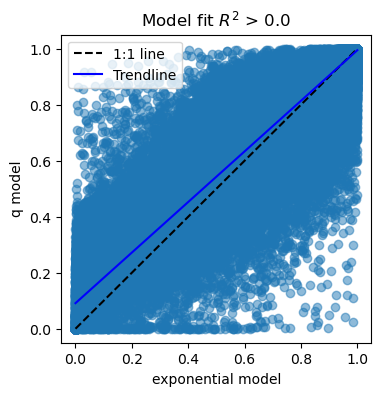

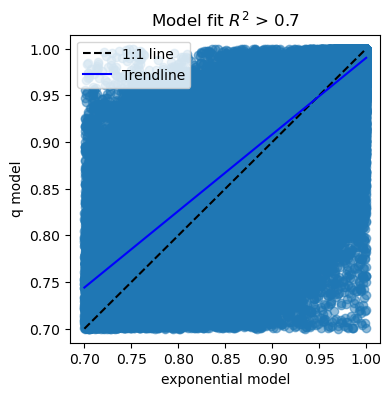

In [920]:
def plot_R2_models(R2_threshold):
    # Assuming you have a DataFrame named 'df' with columns 'exp_r_squared' and 'q_r_squared'
    # Replace 'df' with your actual DataFrame name

    x = df['exp_r_squared'].values
    y = df['q_r_squared'].values
    success_fit_idx = (x > R2_threshold) & (y > R2_threshold)

    # Create a scatter plot
    plt.figure(figsize=(4, 4))
    plt.scatter(x[success_fit_idx], y[success_fit_idx], alpha=0.5)  # alpha controls point transparency
    plt.title(f'Model fit $R^2$ > {R2_threshold}')
    plt.xlabel('exponential model')
    plt.ylabel('q model')
    plt.ylabel

    # Set the x and y-axis limits to the range [0.8, 1]
    plt.plot([R2_threshold, 1], [R2_threshold, 1], color='k', linestyle='--', label='1:1 line')

    # Add a trendline
    coefficients = np.polyfit(x[success_fit_idx], y[success_fit_idx], 1)
    trendline_x = np.array([R2_threshold, 1])
    trendline_y = coefficients[0] * trendline_x + coefficients[1]
    plt.plot(trendline_x, trendline_y, color='blue', label='Trendline')
    plt.legend()

plot_R2_models(R2_threshold=0.0)
plot_R2_models(R2_threshold=0.7)

# Plot longitudinal distribution (lat,lon)

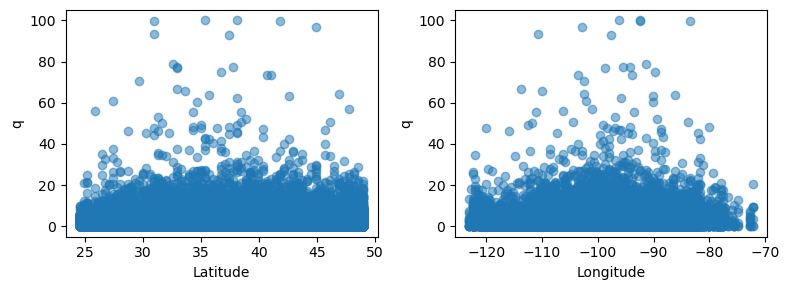

In [792]:
def plot_param_distribution(df=None, model_type=None, parameter=None):

    varname = f"{model_type}_{parameter}"
    # Create a figure and a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    # Scatter plot for latitude vs. q
    axs[0].scatter(df['latitude'], df[varname], alpha=0.5)
    axs[0].set_xlabel('Latitude')
    axs[0].set_ylabel(f'{parameter}')

    # Scatter plot for longitude vs. q
    axs[1].scatter(df['longitude'], df[varname], alpha=0.5)
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel(f'{parameter}')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_param_distribution(df=filtered_df, model_type="q", parameter="q")

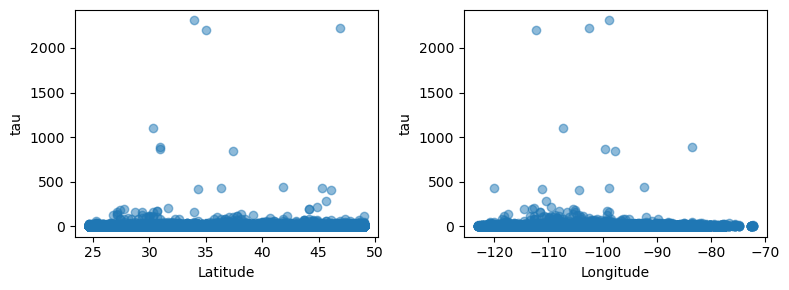

In [793]:
plot_param_distribution(df=filtered_df, model_type="exp", parameter="tau")

# Map plots

In [921]:
# Define the three colors in the colormap
import matplotlib.colors as mcolors
colors = ['#d8b365', '#f5f5f5', '#5ab4ac']

# Create a custom colormap
# cmap = mcolors.LinearSegmentedColormap.from_list('custom_BrBG', colors, N=256)
cmap = "BrBG"

In [922]:
def create_mean_dataarray(df=None, model_type=None, parameter=None):
    varname = f"{model_type}_{parameter}"
    mean_values = df.groupby(['latitude', 'longitude'])[varname].mean()
    data_array = mean_values.reset_index().pivot(index='latitude', columns='longitude', values=varname)
    return data_array

In [923]:
def plot_map(data_array=None, parameter=None, norm=None):
    # Create a figure and axes with Cartopy projection
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Create a grid of lat and lon coordinates
    lons, lats = np.meshgrid(data_array.columns, data_array.index)
    # Plot the heatmap using Cartopy
    im = ax.pcolormesh(lons, lats, data_array.values, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),) #, vmin=vmin, vmax=vmax)

    # Add coastlines
    ax.coastlines()

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label=f'Mean {parameter}')
    cbar.ax.set_position([0.92, 0.1, 0.02, 0.8])
    
    # Set plot title and labels
    ax.set_title(f'Mean {parameter} per pixel')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()
    plt.tight_layout()

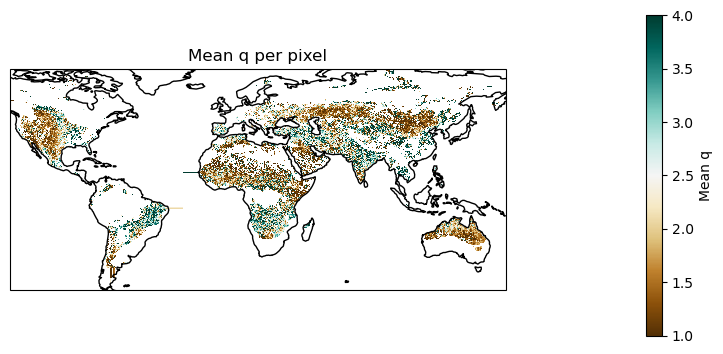

<Figure size 640x480 with 0 Axes>

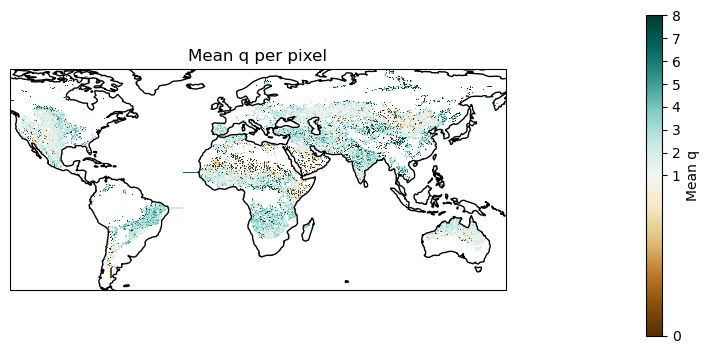

<Figure size 640x480 with 0 Axes>

In [924]:
da_q = create_mean_dataarray(df=filtered_df, model_type="q", parameter="q")

norm = TwoSlopeNorm(vmin=1, vcenter=2.5, vmax=4)
plot_map(data_array=da_q, parameter="q", norm=norm)
norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=8)
plot_map(data_array=da_q, parameter="q", norm=norm)

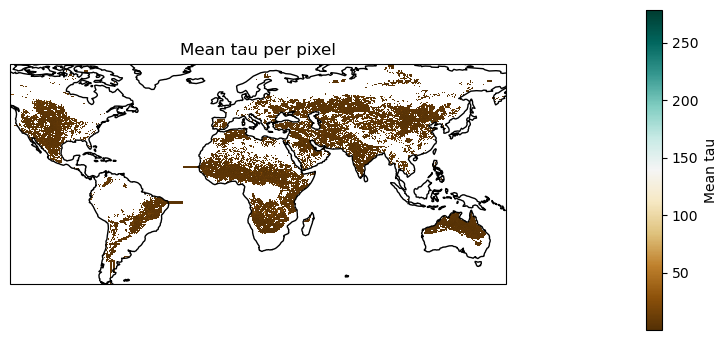

<Figure size 640x480 with 0 Axes>

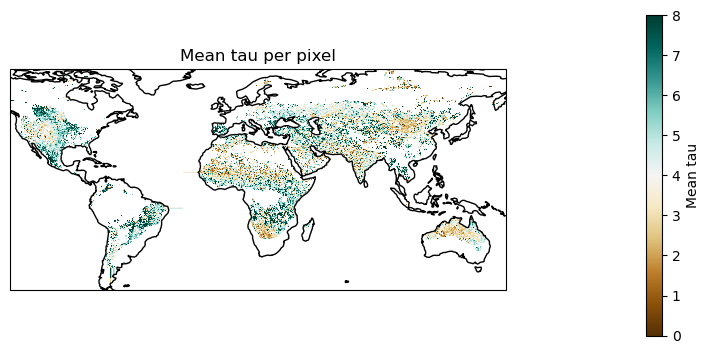

<Figure size 640x480 with 0 Axes>

In [925]:
da_q = create_mean_dataarray(df=filtered_df, model_type="exp", parameter="tau")
plot_map(data_array=da_q, parameter="tau")
norm = TwoSlopeNorm(vmin=0, vcenter=4, vmax=8)
plot_map(data_array=da_q, parameter="tau", norm=norm)

In [926]:
filtered_df["q_k_dernormalize"] = filtered_df["q_k"] * (filtered_df["max_sm"] - filtered_df["min_sm"]) * 50

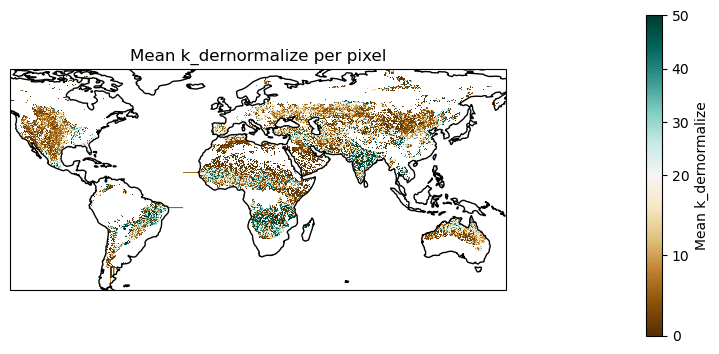

<Figure size 640x480 with 0 Axes>

In [929]:
da_knorm = create_mean_dataarray(df=filtered_df, model_type="q", parameter="k_dernormalize")
norm = TwoSlopeNorm(vmin=0, vcenter=20, vmax=50)
plot_map(data_array=da_knorm, parameter="k_dernormalize", norm=norm)

In [930]:
filtered_df["q_AET/PET"] = filtered_df["q_k_dernormalize"]/filtered_df["pet"]

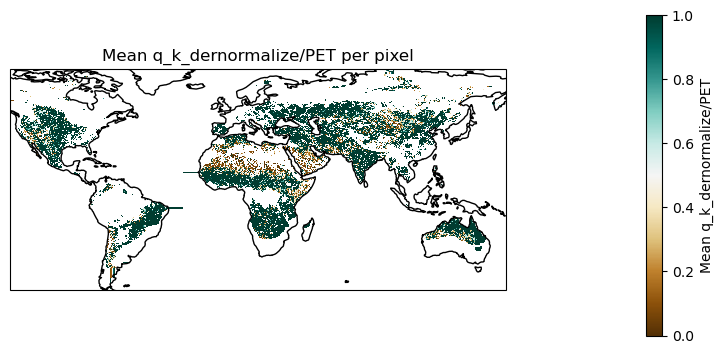

<Figure size 640x480 with 0 Axes>

In [932]:
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
da_AETfrac = create_mean_dataarray(df=filtered_df, model_type="q", parameter="AET/PET")
plot_map(data_array=da_AETfrac, parameter="q_k_dernormalize/PET", norm=norm)

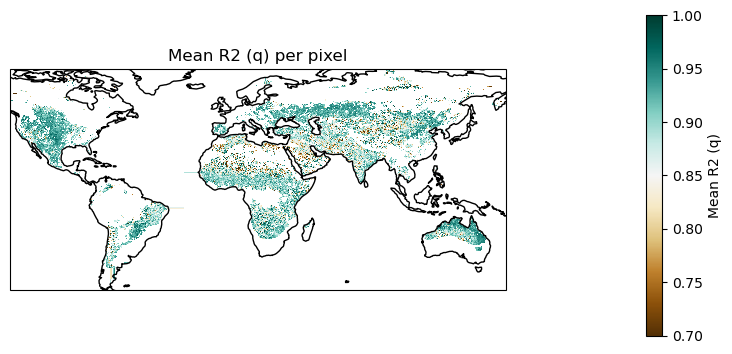

<Figure size 640x480 with 0 Axes>

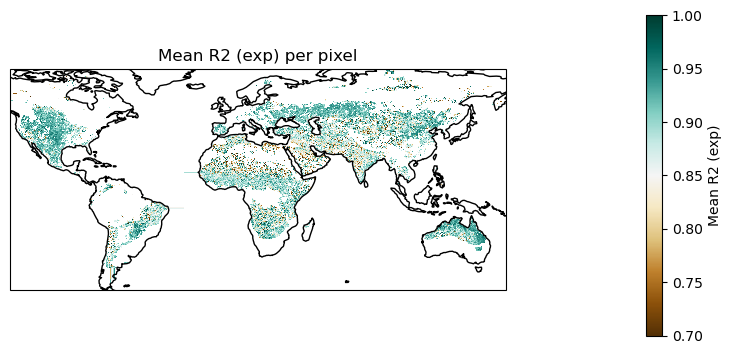

<Figure size 640x480 with 0 Axes>

In [933]:
norm = TwoSlopeNorm(vmin=0.7, vcenter=(0.7+1.0)/2, vmax=1.0)
da_R2_q = create_mean_dataarray(df=filtered_df2, model_type="q", parameter="r_squared")
plot_map(data_array=da_R2_q, parameter="R2 (q)", norm=norm)

da_R2_exp = create_mean_dataarray(df=filtered_df2, model_type="exp", parameter="r_squared")
plot_map(data_array=da_R2_exp, parameter="R2 (exp)", norm=norm)
# norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=8)
# plot_map(data_array=da_q, parameter="q", norm=norm)

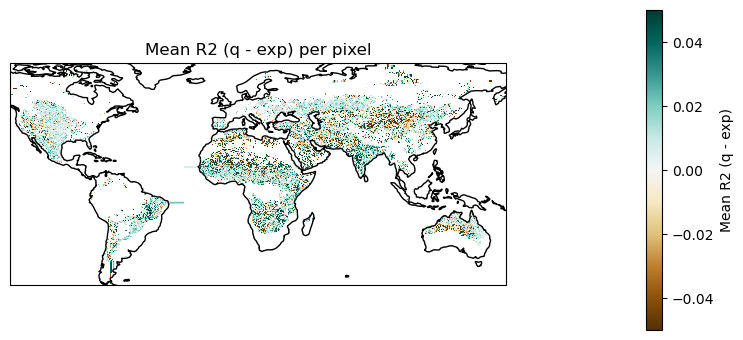

<Figure size 640x480 with 0 Axes>

In [934]:
norm = TwoSlopeNorm(vmin=-0.05, vcenter=0, vmax=0.05)
diff_R2 = create_mean_dataarray(df=filtered_df2, model_type="", parameter="diff_R2")
plot_map(data_array=diff_R2, parameter="R2 (q - exp)", norm=norm)

# Boxplot

In [16]:
import seaborn as sns
# Define the specific order for your categories.
vegetation_categories = ["BAR", "OSH", "CNM", "WSA", "SAV", "GRA", "CRO"]
colors = ["#7A422A", "#C99728", "#229954", "#4C6903", "#92BA31", "#13BFB2", "#F7C906"]

In [17]:
n_bins = 10
sand_bins = [i * 0.1 for i in range(11)]
ai_bins = [i * 0.25 for i in range(9)]
filtered_df['sand_bins'] = pd.cut(filtered_df['sand_fraction'], bins=sand_bins, include_lowest=True)
filtered_df['ai_bins'] = pd.cut(filtered_df['AI'], bins=ai_bins, include_lowest=True)

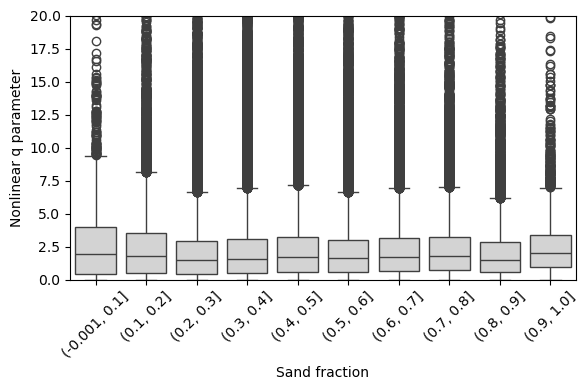

In [937]:
plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='sand_bins', y='q_q', data=filtered_df, boxprops=dict(facecolor='lightgray'))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Nonlinear q parameter")
ax.set_xlabel("Sand fraction")
ax.set_ylim(0, 20)
plt.tight_layout()

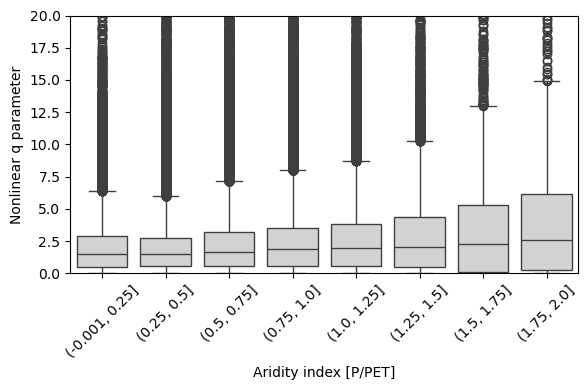

In [938]:
plt.figure(figsize=(6, 4))
ax = sns.boxplot(x='ai_bins', y='q_q', data=filtered_df, boxprops=dict(facecolor='lightgray'))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Nonlinear q parameter")
ax.set_xlabel("Aridity index [P/PET]")
ax.set_ylim(0, 20)
plt.tight_layout()

In [29]:
df.columns

Index(['Unnamed: 0', 'EASE_row_index', 'EASE_column_index', 'event_start',
       'event_end', 'time', 'sm', 'min_sm', 'max_sm', 'pet', 'exp_delta_theta',
       'exp_theta_w', 'exp_tau', 'exp_r_squared', 'exp_y_opt', 'q_k', 'q_q',
       'q_delta_theta', 'q_r_squared', 'q_y_opt', 'id_x', 'latitude',
       'longitude', 'sand_fraction', 'IGBP_landcover', 'id_y', 'AI', 'class',
       'name', 'description', 'abbreviation', '_diff_R2'],
      dtype='object')

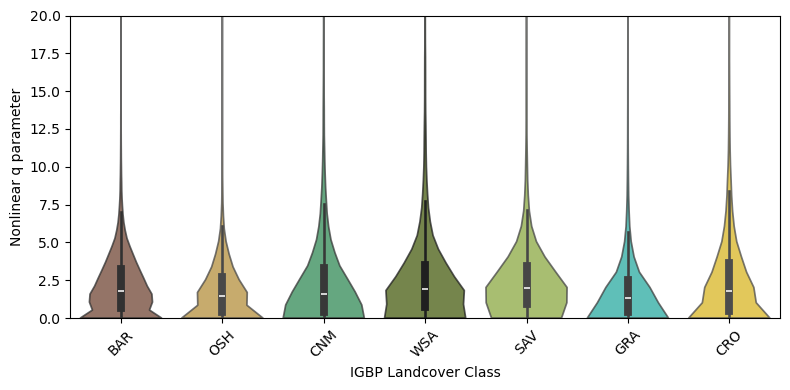

In [939]:


# Create a color palette dictionary
palette_dict = dict(zip(vegetation_categories, colors))

fig, ax =  plt.subplots(figsize=(8, 4))
for i, category in enumerate(vegetation_categories):
    subset = filtered_df[filtered_df['abbreviation'] == category]
    sns.violinplot(x='abbreviation', y='q_q', data=subset, order=[category], color=colors[i], ax=ax, alpha=0.75, cut=0)

# ax = sns.violinplot(x='abbreviation', y='q_q', data=filtered_df, order=vegetation_orders, palette=palette_dict) # boxprops=dict(facecolor='lightgray'), 
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Nonlinear q parameter")
ax.set_xlabel("IGBP Landcover Class")
ax.set_ylim(0, 20)
plt.tight_layout()

/tmp/ipykernel_1434949/3086871283.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


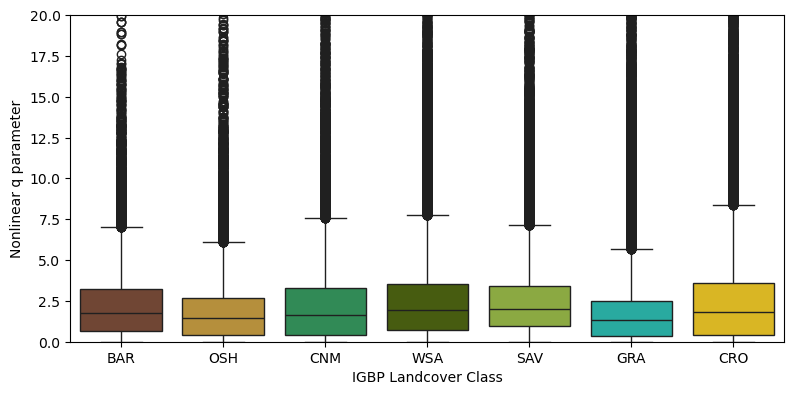

In [941]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the boxplot with specified colors and increased alpha
sns.boxplot(
    x='abbreviation',
    y='q_q',
    data=filtered_df,
    # hue = colors, 
    order=vegetation_categories,
    palette=colors,
    ax=ax
)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor(mcolors.to_rgba((r, g, b), alpha=0.5))

# Optionally, adjust layout
plt.tight_layout()
ax.set_ylabel("Nonlinear q parameter")
ax.set_xlabel("IGBP Landcover Class")
# Show the plot
ax.set_ylim(0, 20)
plt.show()

# Vegetation deep dive

## R2 from q vs tau

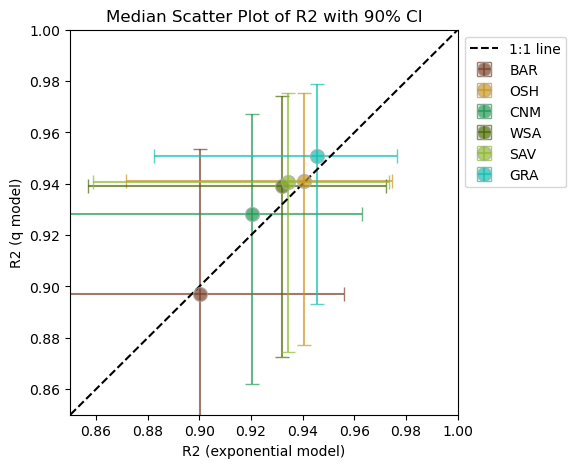

In [944]:
# Assuming 'df' is your DataFrame, 'vegetation_class' is your categorical column and 'value' is the numerical column.

# Set the figure size for better visibility
plt.figure(figsize=(5, 5))

# Get unique categories
categories = vegetation_categories

# Initialize a dictionary to store the medians and CIs
stats_dict = {}

# Calculate median and 90% confidence intervals for each vegetation class
for i, category in enumerate(categories[:-1]):
    subset = filtered_df[filtered_df['abbreviation'] == category]
    
    # Median calculation
    exp_median = subset['exp_r_squared'].median()
    q_median = subset['q_r_squared'].median()
    
    # 90% CI calculation, using the 5th and 95th percentiles
    exp_ci_low, exp_ci_high = np.percentile(subset['exp_r_squared'], [25, 75])
    q_ci_low, q_ci_high = np.percentile(subset['q_r_squared'], [25, 75])
    
    # Store in dict
    stats_dict[category] = {
        'exp_median': exp_median,
        'q_median': q_median,
        'exp_ci': (exp_median - exp_ci_low, exp_ci_high - exp_median),
        'q_ci': (q_median - q_ci_low, q_ci_high - q_median),
        'color': colors[i]
    }

# Now plot medians with CIs
for category, stats in stats_dict.items():
    plt.errorbar(stats['exp_median'], stats['q_median'],
                 xerr=np.array([[stats['exp_ci'][0]], [stats['exp_ci'][1]]]),
                 yerr=np.array([[stats['q_ci'][0]], [stats['q_ci'][1]]]),
                 fmt='o', label=category, capsize=5, capthick=2, color=stats['color'], alpha=0.7,markersize=10 , mec='darkgray', mew=1)

# Add a trendline
# Set the x and y-axis limits to the range [0.8, 1]
plt.plot([0.8, 1], [0.8, 1], color='k', linestyle='--', label='1:1 line')

# Add labels and title
plt.xlabel('R2 (exponential model)')
plt.ylabel('R2 (q model)')
plt.title('Median Scatter Plot of R2 with 90% CI')

# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim(0.85, 1.0)
plt.ylim(0.85, 1.0)

ax.set_ylabel("Nonlinear q parameter")
ax.set_xlabel("IGBP Landcover Class")

# Show the plot
plt.show()

## Density distribution

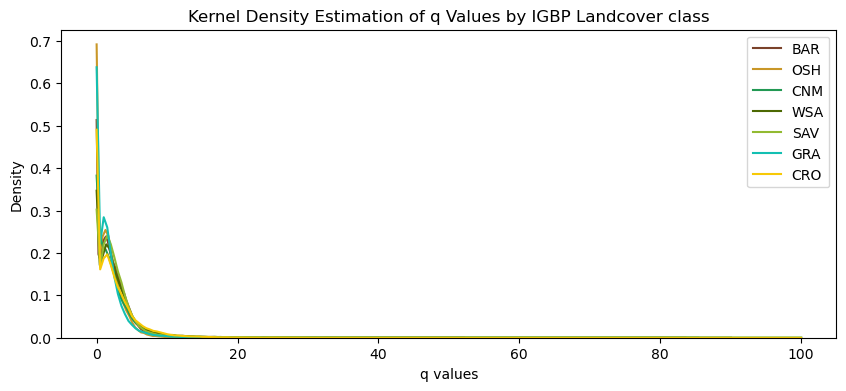

In [945]:
plt.figure(figsize=(10, 4))
for i, category in enumerate(vegetation_categories):
    subset = filtered_df[filtered_df['abbreviation'] == category]
    sns.kdeplot(subset['q_q'], label=category, bw_adjust=0.5, color=colors[i], cut=0)
# Set titles and labels
plt.title('Kernel Density Estimation of q Values by IGBP Landcover class')
plt.xlabel('q values')
plt.ylabel('Density')

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Reconstruction of loss function

In [946]:
from functions import q_drydown, exponential_drydown, loss_model

### Each vegetation

/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

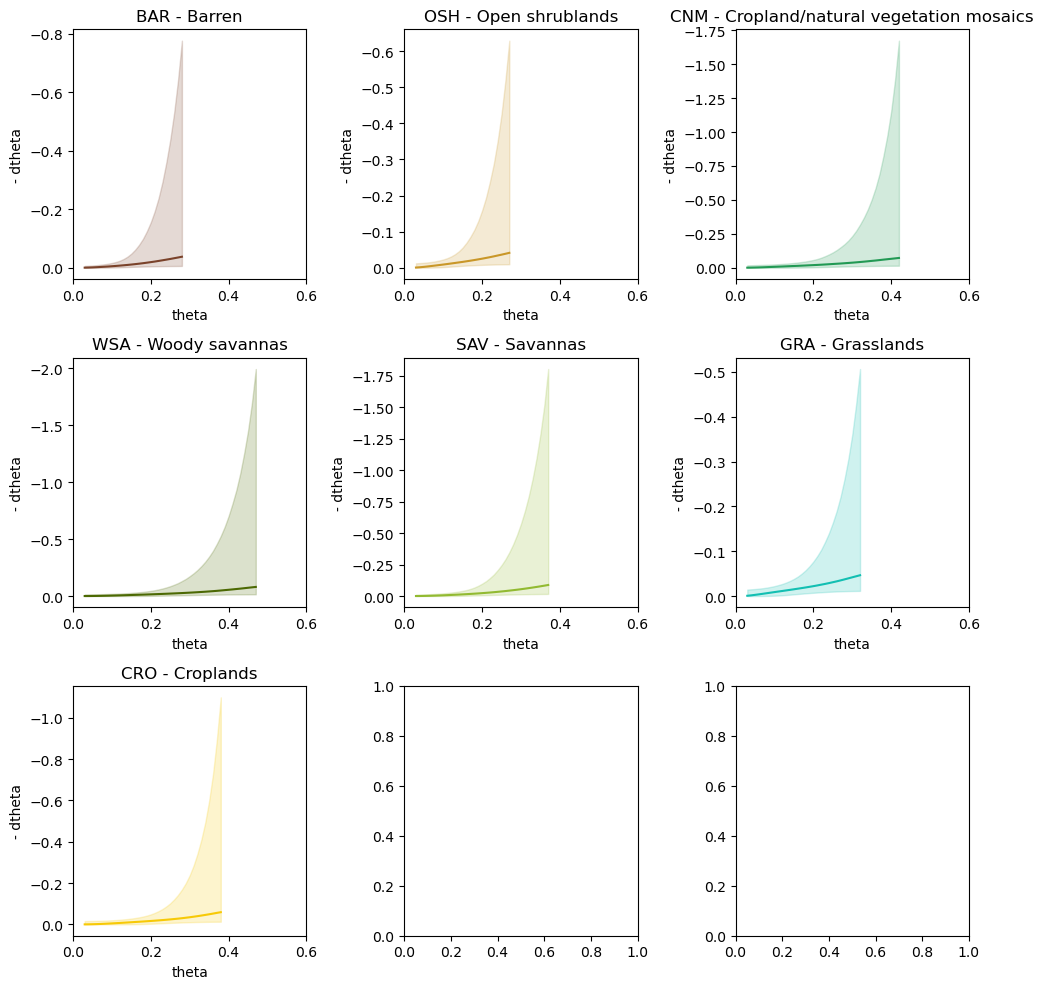

In [947]:
theta = np.arange(0, 1, 0.01)
results = {}
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(vegetation_categories):
    if i >= 9:  # We only have 7 categories
        break
    ax = axes[i]  # Select the corresponding subplot axis
    category_dtheta = []
    category_data = filtered_df[filtered_df['abbreviation'] == category]
    
    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = category_data['min_sm'].quantile(0.10)
    theta_max = category_data['max_sm'].quantile(0.90)
    
    for _, row in category_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        min_sm = row['min_sm']
        max_sm = row['max_sm']
        
        denormalized_k = k * (max_sm-min_sm)
        
        if (theta_max-theta_min)!=0:
            dtheta = loss_model(theta, q, denormalized_k, theta_wp=theta_min, theta_star=theta_max)
            category_dtheta.append(dtheta)

    # Convert to a DataFrame for easier percentile and median calculations
    _dtheta_df = pd.DataFrame(category_dtheta, columns=theta)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta_df = _dtheta_df[theta_range]

    # Calculate median and percentiles for each theta
    median_losses = dtheta_df.median()
    perc_10_losses = dtheta_df.quantile(0.10)
    perc_90_losses = dtheta_df.quantile(0.90)
    

    # Store results for later use
    results[category] = {
        'median': median_losses,
        'perc_10': perc_10_losses,
        'perc_90': perc_90_losses
    }
    

    # Plot median line
    ax.plot(theta_range, median_losses, label=f'{category} Median', color=colors[i])

    # Fill between the 10th and 90th percentile lines
    ax.fill_between(theta_range, perc_10_losses, perc_90_losses, alpha=0.2, color=colors[i])
    ax.invert_yaxis()
    ax.set_xlabel('theta')
    ax.set_ylabel('- dtheta')
    ax.set_xlim([0, 0.6])
    
    full_name = IGBPclass.loc[IGBPclass["abbreviation"]==category, "name"].values[0]
    ax.set_title(f'{category} - {full_name}')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()

# Show the plot
plt.show()

### Loss function (y axis normalized)

/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

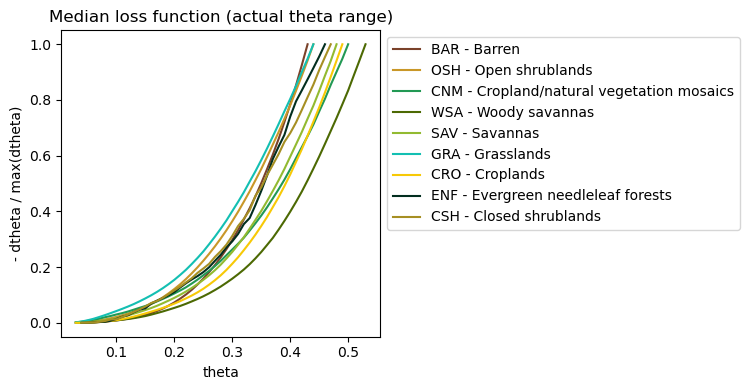

In [36]:
theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))
axes = axes.flatten()
# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(vegetation_categories):
    if i >= 9:  # We only have 7 categories
        break
    category_dtheta = []
    category_data = filtered_df[filtered_df['abbreviation'] == category]
    
    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = category_data['min_sm'].quantile(0.10)
    theta_max = category_data['max_sm'].quantile(0.90)
    
    for _, row in category_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        min_sm = row['min_sm']
        max_sm = row['max_sm']
        
        denormalized_k = k * (max_sm-min_sm)
        dtheta = loss_model(theta, q, denormalized_k, theta_wp=min_sm, theta_star=max_sm)
        category_dtheta.append(dtheta)

    # Convert to a DataFrame for easier percentile and median calculations
    _dtheta_df = pd.DataFrame(category_dtheta, columns=theta)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta_df = _dtheta_df[theta_range]

    # Calculate median and percentiles for each theta
    median_losses = dtheta_df.median()
    
    median_losses_norm = median_losses / median_losses.iloc[-1]
    

    # Plot median line
    full_name = IGBPclass.loc[IGBPclass["abbreviation"]==category, "name"].values[0]
    ax.plot(theta_range, median_losses_norm, label=f'{category} - {full_name}', color=colors[i])

# ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta / max(dtheta)')
ax.set_title('Median loss function (actual theta range)')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

### Loss function (original shape)

/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

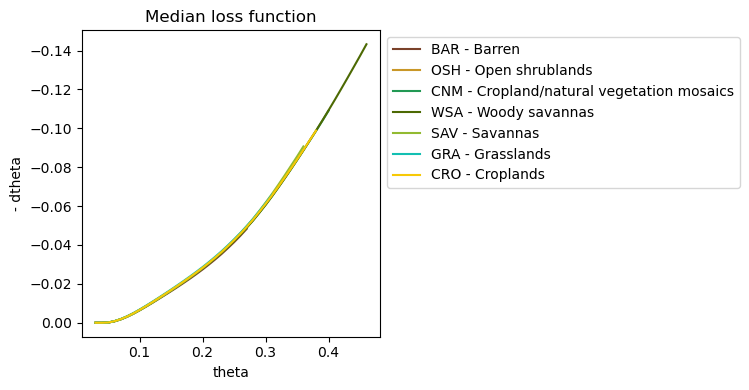

In [1005]:
theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))
axes = axes.flatten()
# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(vegetation_categories):
    if i >= 9:  # We only have 7 categories
        break
    category_data = filtered_df3[filtered_df3['abbreviation'] == category]
    
    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = category_data['min_sm'].quantile(0.10)
    theta_max = category_data['max_sm'].quantile(0.90)
    
    for _, row in category_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        
        denormalized_k = k * (max_sm-min_sm)
        dtheta = loss_model(theta, q, denormalized_k, theta_wp=min_sm, theta_star=max_sm)
        category_dtheta.append(dtheta)
        
        # dtheta = loss_model(theta, q, k, theta_wp=0., theta_star=1.)
        # category_dtheta.append(dtheta)

    # Convert to a DataFrame for easier percentile and median calculations
    _dtheta_df = pd.DataFrame(category_dtheta, columns=theta)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta_df = _dtheta_df[theta_range]

    # Calculate median and percentiles for each theta
    median_losses = dtheta_df.median()

    # Plot median line
    full_name = IGBPclass.loc[IGBPclass["abbreviation"]==category, "name"].values[0]
    ax.plot(theta_range, median_losses, label=f'{category} - {full_name}', color=colors[i])

ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median loss function')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

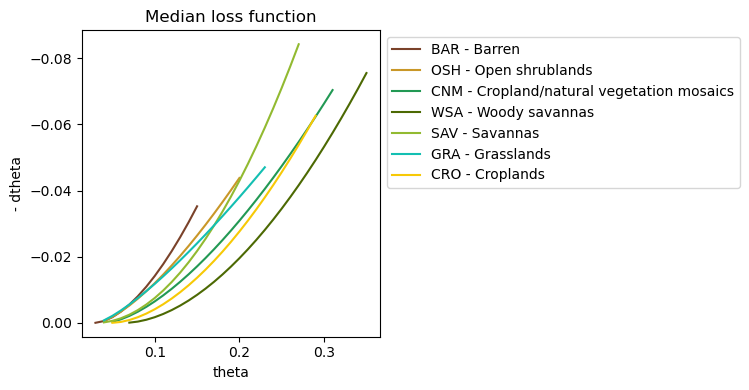

In [33]:
theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))

# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(vegetation_categories):
    category_data = filtered_df3[filtered_df3['abbreviation'] == category]
    
    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = category_data['min_sm'].median() #.quantile(0.10)
    theta_max = category_data['max_sm'].median() #.quantile(0.90)
    denormalized_k = (category_data['q_k'] * (category_data['max_sm']-category_data['min_sm'])).median()
    q = category_data['q_q'].median()

    _dtheta = loss_model(theta, q, denormalized_k, theta_wp=theta_min, theta_star=theta_max)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta = _dtheta[(theta >= theta_min) & (theta <= theta_max)]

    # Plot median line
    full_name = IGBPclass.loc[IGBPclass["abbreviation"]==category, "name"].values[0]
    ax.plot(theta_range, dtheta, label=f'{category} - {full_name}', color=colors[i])

ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median loss function')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

### Loss function (x and y axis normalized)

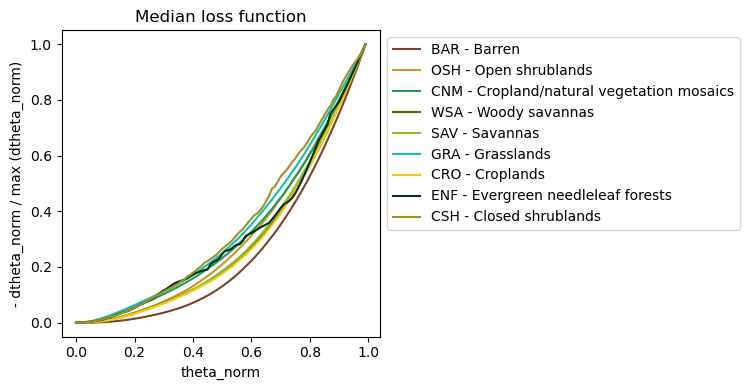

In [38]:
theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))
axes = axes.flatten()
# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(vegetation_categories):
    if i >= 9:  # We only have 7 categories
        break
    category_dtheta = []
    
    for _, row in filtered_df[filtered_df['abbreviation'] == category].iterrows():
        q = row['q_q']
        k = row['q_k']
        dtheta = loss_model(theta, q, k, theta_wp=0., theta_star=1.)
        category_dtheta.append(dtheta)

    # Convert to a DataFrame for easier percentile and median calculations
    dtheta_df = pd.DataFrame(category_dtheta, columns=theta)

    # Calculate median and percentiles for each theta
    median_losses = dtheta_df.median()
    
    median_losses_norm = median_losses / median_losses[0.99]
    

    # Plot median line
    full_name = IGBPclass.loc[IGBPclass["abbreviation"]==category, "name"].values[0]
    ax.plot(theta, median_losses_norm, label=f'{category} - {full_name}', color=colors[i])

# ax.invert_yaxis()
ax.set_xlabel('theta_norm')
ax.set_ylabel('- dtheta_norm / max (dtheta_norm)')
ax.set_title('Median loss function')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

### Loss function (x axis normalized)

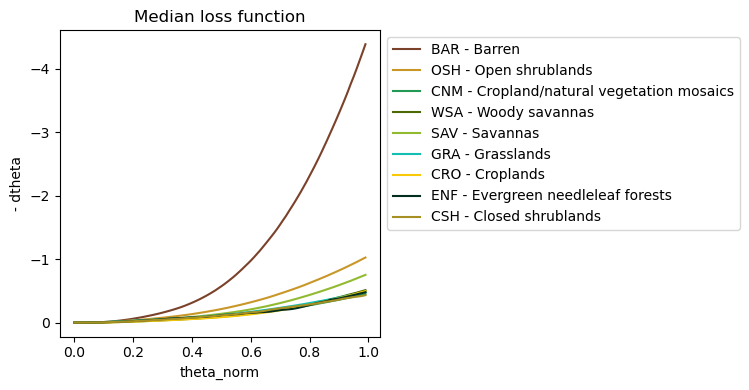

In [39]:


theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))
axes = axes.flatten()
# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(vegetation_categories):
    if i >= 9:  # We only have 7 categories
        break
    category_dtheta = []
    
    for _, row in filtered_df[filtered_df['abbreviation'] == category].iterrows():
        q = row['q_q']
        k = row['q_k']
        dtheta = loss_model(theta, q, k, theta_wp=0., theta_star=1.)
        category_dtheta.append(dtheta)

    # Convert to a DataFrame for easier percentile and median calculations
    dtheta_df = pd.DataFrame(category_dtheta, columns=theta)

    # Calculate median and percentiles for each theta
    median_losses = dtheta_df.median()

    # Plot median line
    full_name = IGBPclass.loc[IGBPclass["abbreviation"]==category, "name"].values[0]
    ax.plot(theta, median_losses, label=f'{category} - {full_name}', color=colors[i])

ax.invert_yaxis()
ax.set_xlabel('theta_norm')
ax.set_ylabel('- dtheta')
ax.set_title('Median loss function')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()



## Time variation of q

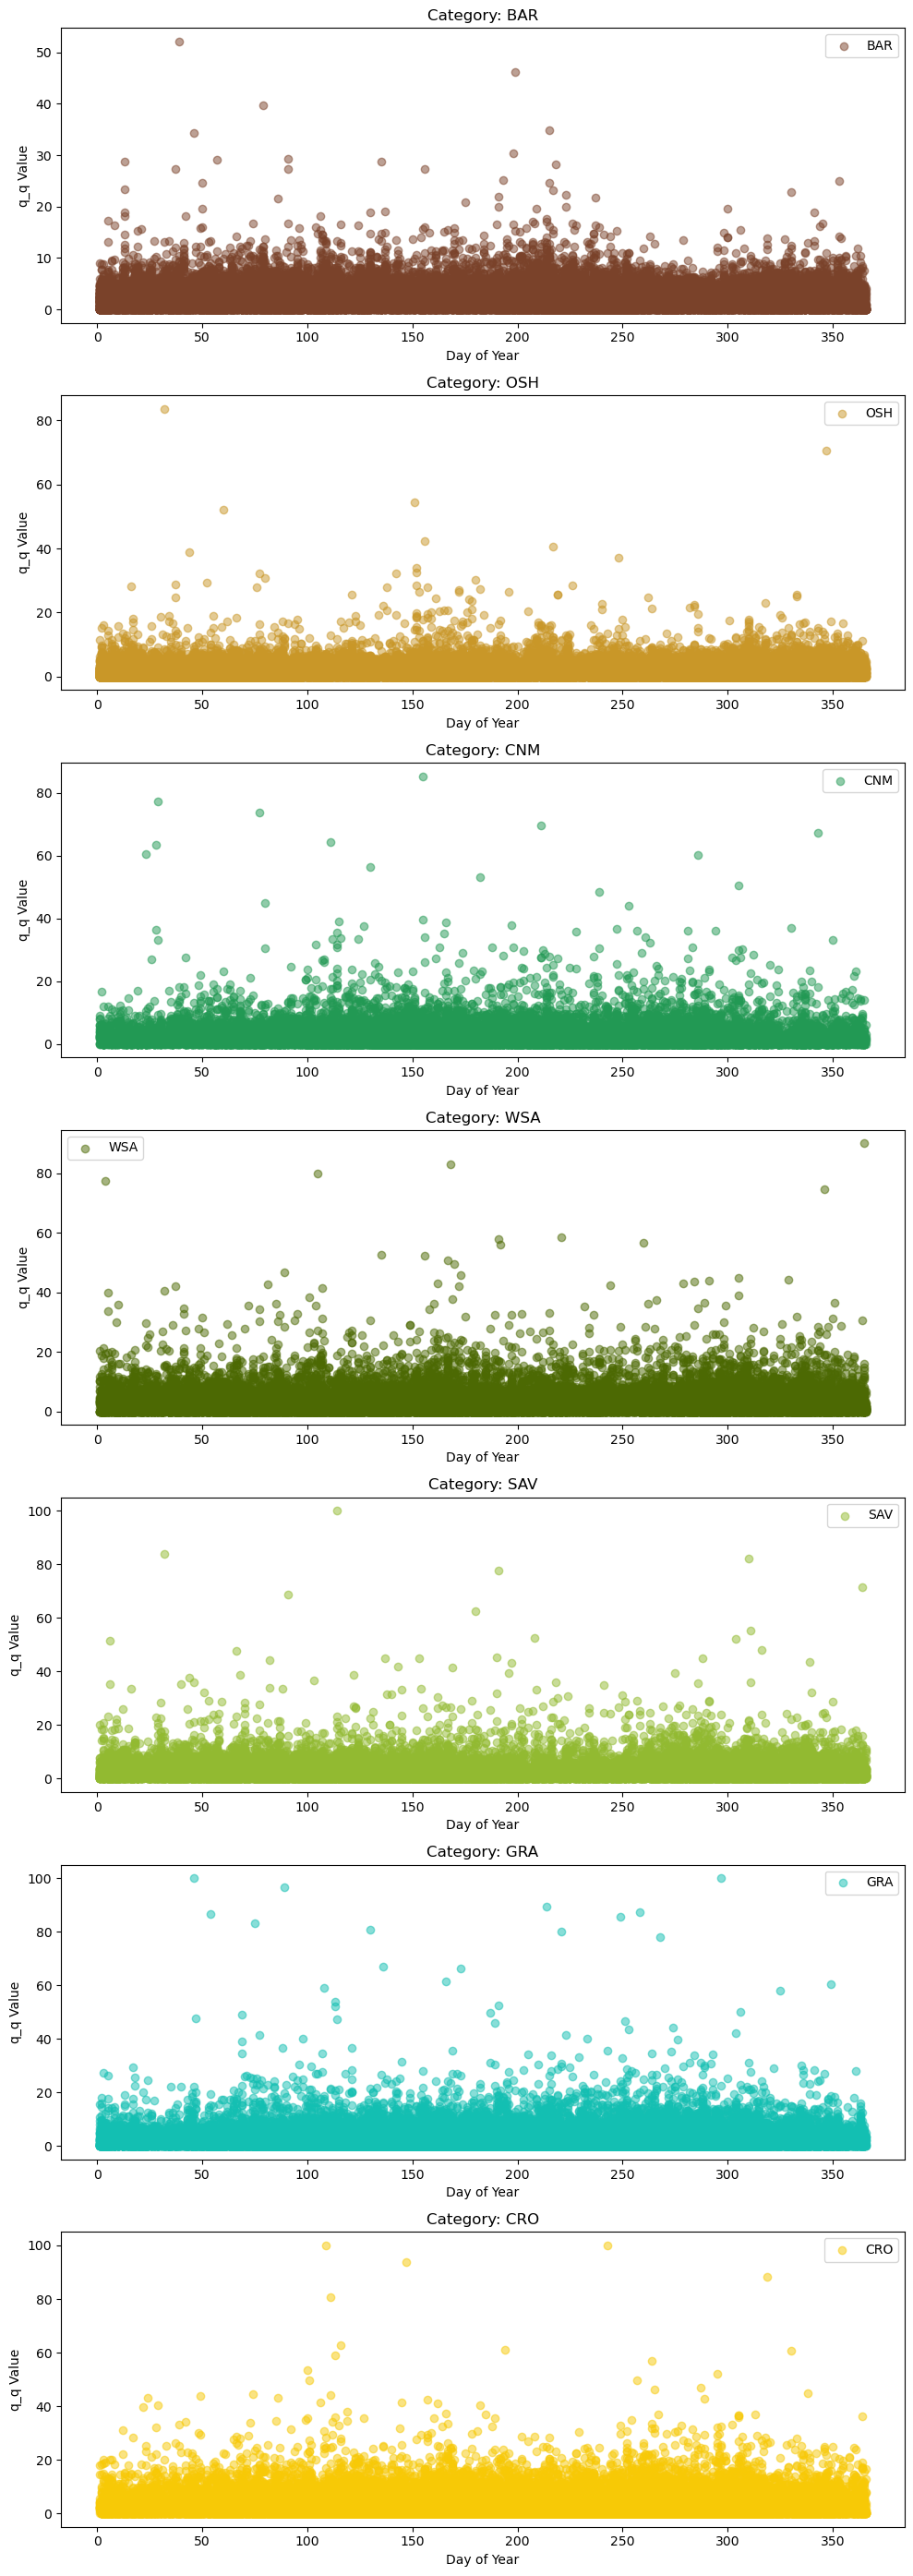

In [950]:
import matplotlib.pyplot as plt

# Extract the day of the year
filtered_df["doy"] = pd.to_datetime(filtered_df['event_start']).dt.dayofyear
num_categories = len(vegetation_categories)
fig, axes = plt.subplots(num_categories, 1, figsize=(10, 4 * num_categories))

for i, category in enumerate(vegetation_categories):
    subset = filtered_df[filtered_df['abbreviation'] == category]
    ax = axes[i] if num_categories > 1 else axes
    ax.scatter(subset['doy'].values, subset['q_q'].values, label=category, color=colors[i], alpha=0.5)
    ax.legend()
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('q_q Value')
    ax.set_title(f'Category: {category}')

plt.tight_layout()
plt.show()


## Time variation of q (all together)

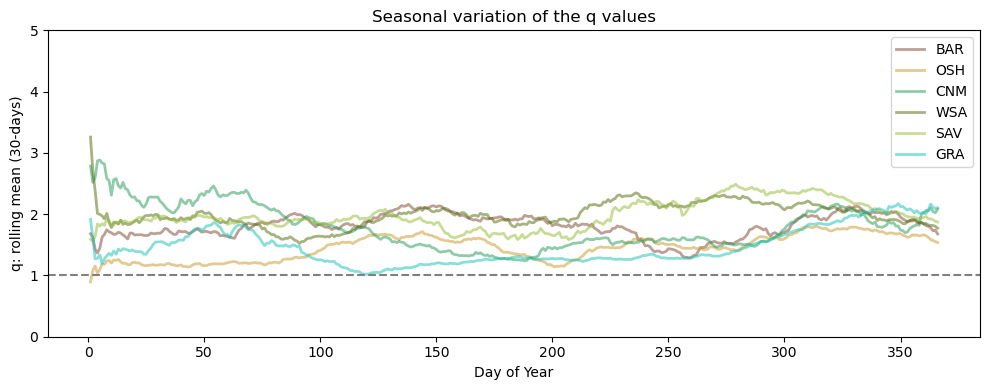

In [952]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming filtered_df, vegetation_order, and colors are defined

# Extract the day of the year
num_categories = len(vegetation_categories[:-1])
fig, ax = plt.subplots(1, figsize=(10, 4))

for i, category in enumerate(vegetation_categories[:-1]):
    subset = filtered_df[filtered_df['abbreviation'] == category]
    
    # Group by day of the year and calculate the median of 'q_q'
    subset = subset.reset_index()
    median_values = subset.groupby('doy')['q_q'].median().rolling(window=30, min_periods=1).mean()

    # Plot the median values
    ax.plot(median_values.index, median_values.values, label=f'{category}', color=colors[i], linewidth=2, alpha=0.5)

ax.legend()
ax.set_ylim([0,5])
ax.set_xlabel('Day of Year')
ax.set_ylabel('q: rolling mean (30-days)')
ax.set_title(f'Seasonal variation of the q values')
plt.axhline(y=1, color='grey', linestyle='--')
plt.tight_layout()
plt.show()


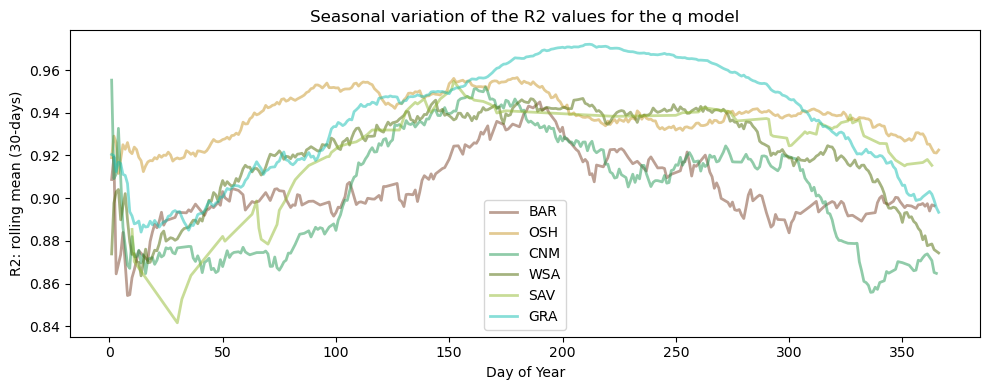

In [894]:

import pandas as pd

# Assuming filtered_df, vegetation_order, and colors are defined

# Extract the day of the year
num_categories = len(vegetation_categories[:-1])
fig, ax = plt.subplots(1, figsize=(10, 4))

for i, category in enumerate(vegetation_categories[:-1]):
    subset = filtered_df[filtered_df['abbreviation'] == category]
    
    # Group by day of the year and calculate the median of 'q_q'
    subset = subset.reset_index()
    median_values = subset.groupby('doy')['q_r_squared'].median().rolling(window=30, min_periods=1).mean()

    # Plot the median values
    ax.plot(median_values.index, median_values.values, label=f'{category}', color=colors[i], linewidth=2, alpha=0.5)

    ax.legend()
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('R2: rolling mean (30-days)')
    ax.set_title(f'Seasonal variation of the R2 values for the q model')

plt.tight_layout()
plt.show()


# Soil deep dive

## R2 plot

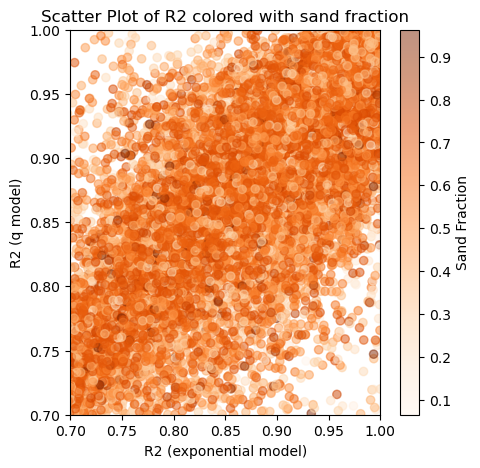

In [895]:
# Assuming 'df' is your DataFrame, 'vegetation_class' is your categorical column and 'value' is the numerical column.

# Set the figure size for better visibility
plt.figure(figsize=(5, 5))

scatter = plt.scatter(filtered_df.exp_r_squared, filtered_df.q_r_squared, c=filtered_df.sand_fraction, cmap='Oranges', alpha=.5)

# Add labels and title
plt.colorbar(scatter, label='Sand Fraction')
plt.xlabel('R2 (exponential model)')
plt.ylabel('R2 (q model)')
plt.title('Scatter Plot of R2 colored with sand fraction')
plt.xlim([0.7, 1.0])
plt.ylim([0.7, 1.0])

# Show the plot
plt.show()

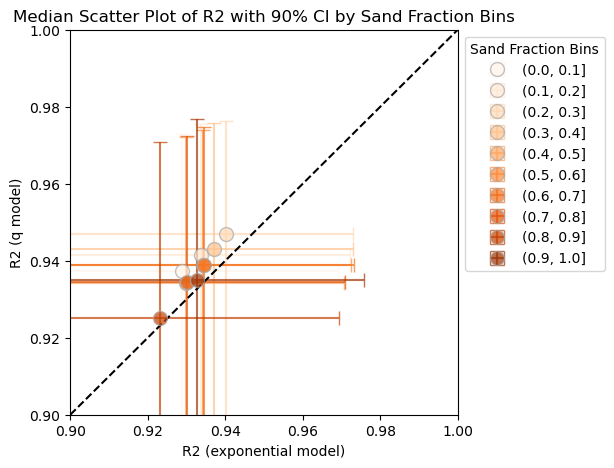

In [994]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'sand_fraction' is your continuous variable.

# Set the figure size for better visibility
plt.figure(figsize=(5, 5))

# Bin the 'sand_fraction' into intervals
bins = np.arange(0, 1.1, 0.1)  # Adjust the range and step as needed
filtered_df['sand_bin'] = pd.cut(filtered_df['sand_fraction'], bins)

# Get unique bins and sort them
sand_bins = [bin for bin in sand_bins if pd.notna(bin)]
sand_bins = sorted(sand_bins, key=lambda x: x.left)  # Sort bins by their left edge

# Initialize a dictionary to store the medians and CIs
stats_dict = {}

# Calculate median and 90% confidence intervals for each sand bin
for i, bin in enumerate(sand_bins):
    subset = filtered_df[filtered_df['sand_bin'] == bin]

    # Check if the subset is empty
    if subset.empty:
        continue

    # Median calculation
    exp_median = subset['exp_r_squared'].median()
    q_median = subset['q_r_squared'].median()
    
    # 90% CI calculation, using the 25th and 75th percentiles
    exp_ci_low, exp_ci_high = np.percentile(subset['exp_r_squared'].dropna(), [25, 75])
    q_ci_low, q_ci_high = np.percentile(subset['q_r_squared'].dropna(), [25, 75])
    
    # Store in dict
    stats_dict[bin] = {
        'exp_median': exp_median,
        'q_median': q_median,
        'exp_ci': (exp_median - exp_ci_low, exp_ci_high - exp_median),
        'q_ci': (q_median - q_ci_low, q_ci_high - q_median),
        'color': plt.cm.Oranges(i / len(sand_bins))  # Color mapping
    }

# Now plot medians with CIs
for bin, stats in stats_dict.items():
    plt.errorbar(stats['exp_median'], stats['q_median'],
                 xerr=np.array([[stats['exp_ci'][0]], [stats['exp_ci'][1]]]),
                 yerr=np.array([[stats['q_ci'][0]], [stats['q_ci'][1]]]),
                 fmt='o', label=str(bin), capsize=5, capthick=2, color=stats['color'], alpha=0.7, markersize=10, mec='darkgray', mew=1)

# Add labels, title, and legend
plt.xlabel('R2 (exponential model)')
plt.ylabel('R2 (q model)')
plt.xlim([0.9, 1.0])
plt.ylim([0.9, 1.0])
plt.title('Median Scatter Plot of R2 with 90% CI by Sand Fraction Bins')
plt.legend(title='Sand Fraction Bins', bbox_to_anchor=(1, 1))

# Add a trendline
plt.plot([0.9, 1], [0.9, 1], color='k', linestyle='--', label='1:1 line')

# Show the plot
plt.show()


## Density plot

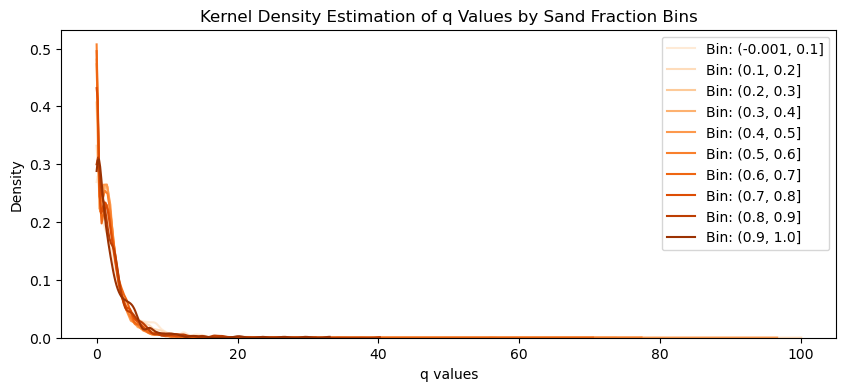

In [902]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'filtered_df' is your DataFrame and 'sand_fraction' is your continuous variable.

# Bin the 'sand_fraction' into intervals
bins = np.arange(0, 1.1, 0.1)  # Adjust the range and step as needed
filtered_df['sand_bin'] = pd.cut(filtered_df['sand_fraction'], bins, include_lowest=True)

# Set the figure size
plt.figure(figsize=(10, 4))

# Get unique bins
sand_bins = filtered_df['sand_bin'].unique()
sand_bins = sorted(sand_bins, key=lambda x: x.left)
# Define a color palette
palette = sns.color_palette("Oranges", len(sand_bins))

# Plotting KDE for each bin
for i, bin in enumerate(sand_bins):
    subset = filtered_df[filtered_df['sand_bin'] == bin]
    sns.kdeplot(subset['q_q'], label=f'Bin: {bin}', bw_adjust=0.5, color=palette[i], cut=0)

# Set titles and labels
plt.title('Kernel Density Estimation of q Values by Sand Fraction Bins')
plt.xlabel('q values')
plt.ylabel('Density')

# Show the legend
plt.legend()

# Show the plot
plt.show()


## Loss function (actual ranges)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'filtered_df' is your DataFrame and 'sand_fraction' is your continuous variable.

# Bin the 'sand_fraction' into intervals
bins = np.arange(0, 1.1, 0.1)  # Adjust the range and step as needed
filtered_df['sand_bin'] = pd.cut(filtered_df['sand_fraction'], bins, include_lowest=True)
sand_bins = sorted(sand_bins, key=lambda x: x.left)  # Sort bins by their left edge

# Set the figure size
fig, ax = plt.subplots(figsize=(4, 4))

# Get unique bins
sand_bins = filtered_df['sand_bin'].unique()
sand_bins = [bin for bin in sand_bins if pd.notna(bin)]

# Define a color palette
palette = plt.cm.Oranges(np.linspace(0, 1, len(sand_bins)))

theta = np.arange(0, 1, 0.01)

# Plotting for each sand bin
for i, bin in enumerate(sand_bins):
    bin_data = filtered_df[filtered_df['sand_bin'] == bin]
    
    category_dtheta = []

    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = bin_data['min_sm'].quantile(0.10)
    theta_max = bin_data['max_sm'].quantile(0.90)
    
    for _, row in bin_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        
        # Assuming 'loss_model' is defined and uses 'theta', 'q', 'k', and other parameters
        denormalized_k = k * (theta_max - theta_min)
        dtheta = loss_model(theta, q, denormalized_k, theta_wp=theta_min, theta_star=theta_max)
        category_dtheta.append(dtheta)
    
    # Convert to a DataFrame
    _dtheta_df = pd.DataFrame(category_dtheta, columns=theta)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta_df = _dtheta_df[theta_range]

    # Calculate median for each theta
    median_losses = dtheta_df.median()

    # Plot median line
    ax.plot(theta_range, median_losses, label=f'Bin: {bin}', color=palette[i])

# Customize plot
ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median Loss Function by Sand Fraction Bins')

# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()


AttributeError: 'float' object has no attribute 'left'

/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

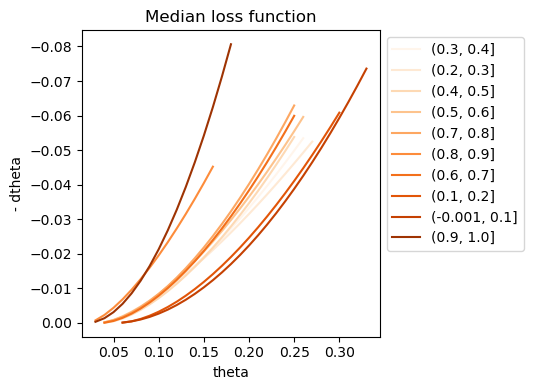

In [39]:
theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))

# Bin the 'sand_fraction' into intervals
bins = np.arange(0, 1.1, 0.1)  # Adjust the range and step as needed
filtered_df3['sand_bin'] = pd.cut(filtered_df3['sand_fraction'], bins, include_lowest=True)

# Get unique bins
sand_bins = filtered_df['sand_bin'].unique()
sand_bins = [bin for bin in sand_bins if pd.notna(bin)]

# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(sand_bins):
    category_data = filtered_df3[filtered_df3['sand_bin'] == category]
    
    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = category_data['min_sm'].median() #.quantile(0.10)
    theta_max = category_data['max_sm'].median() #.quantile(0.90)
    denormalized_k = (category_data['q_k'] * (category_data['max_sm']-category_data['min_sm'])).median()
    q = category_data['q_q'].median()

    _dtheta = loss_model(theta, q, denormalized_k, theta_wp=theta_min, theta_star=theta_max)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta = _dtheta[(theta >= theta_min) & (theta <= theta_max)]

    # Plot median line
    ax.plot(theta_range, dtheta, label=f'{category}', color=plt.cm.Oranges(i / len(sand_bins)))

ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median loss function')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

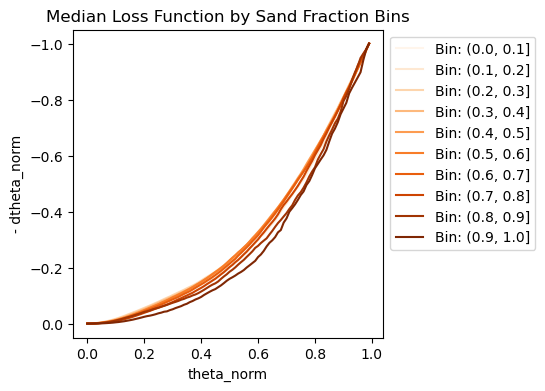

In [ ]:
# Plotting for each sand bin
# Set the figure size
fig, ax = plt.subplots(figsize=(4, 4))

for i, bin in enumerate(sand_bins):
    bin_data = filtered_df[filtered_df['sand_bin'] == bin]
    
    category_dtheta = []
    
    for _, row in bin_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        dtheta = loss_model(theta, q, k, theta_wp=0, theta_star=1)
        category_dtheta.append(dtheta)
    
    # Convert to a DataFrame
    dtheta_df = pd.DataFrame(category_dtheta, columns=theta)

    # Calculate median for each theta
    median_losses = dtheta_df.median()
    median_losses_norm = median_losses / median_losses[0.99] * -1

    # Plot median line
    ax.plot(theta, median_losses_norm, label=f'Bin: {bin}', color=palette[i])

# Customize plot
ax.invert_yaxis()
ax.set_xlabel('theta_norm')
ax.set_ylabel('- dtheta_norm')
ax.set_title('Median Loss Function by Sand Fraction Bins')

# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()


## Aridity index deep dive

### R2 plot

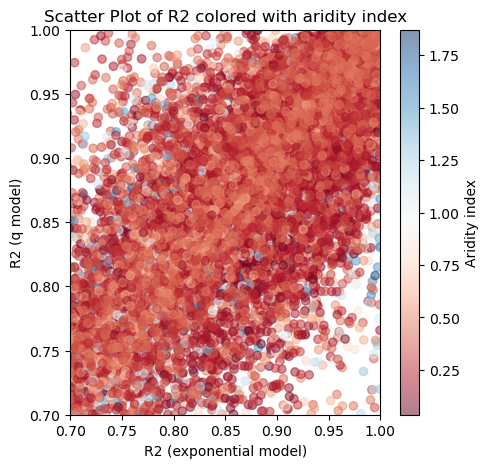

In [904]:
# Assuming 'df' is your DataFrame, 'vegetation_class' is your categorical column and 'value' is the numerical column.

# Set the figure size for better visibility
plt.figure(figsize=(5, 5))

scatter = plt.scatter(filtered_df.exp_r_squared, filtered_df.q_r_squared, c=filtered_df.AI, cmap='RdBu', alpha=.5)

# Add labels and title
plt.colorbar(scatter, label='Aridity index')
plt.xlabel('R2 (exponential model)')
plt.ylabel('R2 (q model)')
plt.title('Scatter Plot of R2 colored with aridity index')
plt.xlim([0.7, 1.0])
plt.ylim([0.7, 1.0])

# Show the plot
plt.show()

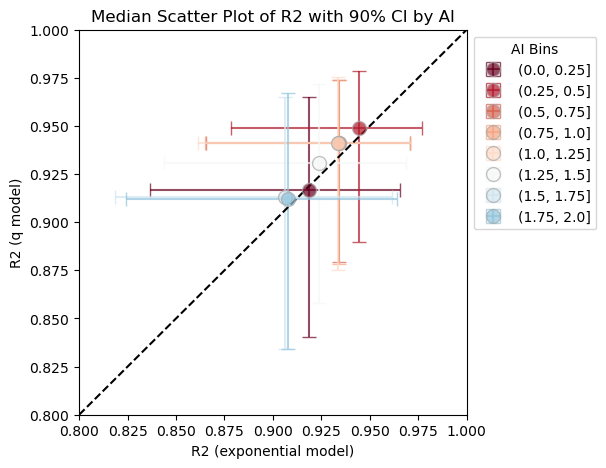

In [997]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'sand_fraction' is your continuous variable.

# Set the figure size for better visibility
plt.figure(figsize=(5, 5))
ai_bins = [i * 0.25 for i in range(9)]

# Bin the 'sand_fraction' into intervals
filtered_df['ai_bin'] = pd.cut(filtered_df['AI'], ai_bins)

# Get unique bins and sort them
ai_bin = filtered_df['ai_bin'].unique()
ai_bin = [bin for bin in ai_bin if pd.notna(bin)]
ai_bin = sorted(ai_bin, key=lambda x: x.left)  # Sort bins by their left edge


# Initialize a dictionary to store the medians and CIs
stats_dict = {}

# Calculate median and 90% confidence intervals for each sand bin
for i, bin in enumerate(ai_bin):
    subset = filtered_df[filtered_df['ai_bin'] == bin]

    # Check if the subset is empty
    if subset.empty:
        continue

    # Median calculation
    exp_median = subset['exp_r_squared'].median()
    q_median = subset['q_r_squared'].median()
    
    # 90% CI calculation, using the 25th and 75th percentiles
    exp_ci_low, exp_ci_high = np.percentile(subset['exp_r_squared'].dropna(), [25, 75])
    q_ci_low, q_ci_high = np.percentile(subset['q_r_squared'].dropna(), [25, 75])
    
    # Store in dict
    stats_dict[bin] = {
        'exp_median': exp_median,
        'q_median': q_median,
        'exp_ci': (exp_median - exp_ci_low, exp_ci_high - exp_median),
        'q_ci': (q_median - q_ci_low, q_ci_high - q_median),
        'color': plt.cm.RdBu(i / len(sand_bins))  # Color mapping
    }

# Now plot medians with CIs
for bin, stats in stats_dict.items():
    plt.errorbar(stats['exp_median'], stats['q_median'],
                 xerr=np.array([[stats['exp_ci'][0]], [stats['exp_ci'][1]]]),
                 yerr=np.array([[stats['q_ci'][0]], [stats['q_ci'][1]]]),
                 fmt='o', label=str(bin), capsize=5, capthick=2, color=stats['color'], alpha=0.7, markersize=10, mec='darkgray', mew=1)

# Add labels, title, and legend
plt.xlabel('R2 (exponential model)')
plt.ylabel('R2 (q model)')
plt.xlim([0.8, 1.0])
plt.ylim([0.8, 1.0])
plt.title('Median Scatter Plot of R2 with 90% CI by AI')
plt.legend(title='AI Bins', bbox_to_anchor=(1, 1))

# Add a trendline
plt.plot([0.8, 1], [0.8, 1], color='k', linestyle='--', label='1:1 line')

# Show the plot
plt.show()


### Distribution

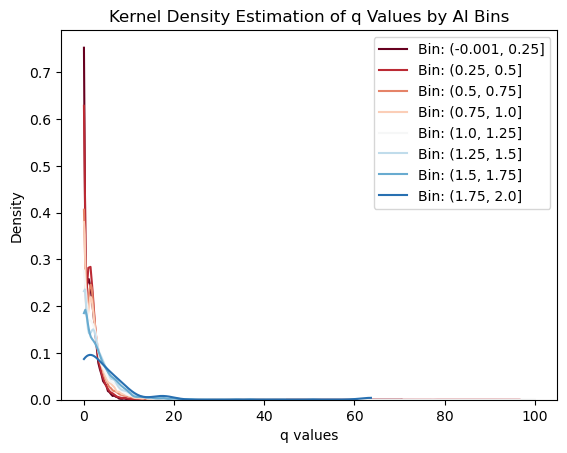

In [906]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a color palette
palette = plt.cm.RdBu(np.linspace(0, 1, len(ai_bins)))

# Assuming 'filtered_df' is your DataFrame and 'sand_fraction' is your continuous variable.
# Bin the 'sand_fraction' into intervals
ai_bins = [i * 0.25 for i in range(9)]
filtered_df['ai_bin'] = pd.cut(filtered_df['AI'], ai_bins, include_lowest=True)
# Get unique bins and sort them
ai_bin = filtered_df['ai_bin'].unique()
ai_bin = sorted(ai_bin, key=lambda x: x.left)  # Sort bins by their left edge
# Bin the 'sand_fraction' into intervals
# Plotting KDE for each bin
for i, bin in enumerate(ai_bin):
    subset = filtered_df[filtered_df['ai_bin'] == bin]
    sns.kdeplot(subset['q_q'], label=f'Bin: {bin}', bw_adjust=0.5, color=palette[i], cut=0)

# Set titles and labels
plt.title('Kernel Density Estimation of q Values by AI Bins')
plt.xlabel('q values')
plt.ylabel('Density')

# Show the legend
plt.legend()

# Show the plot
plt.show()


/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

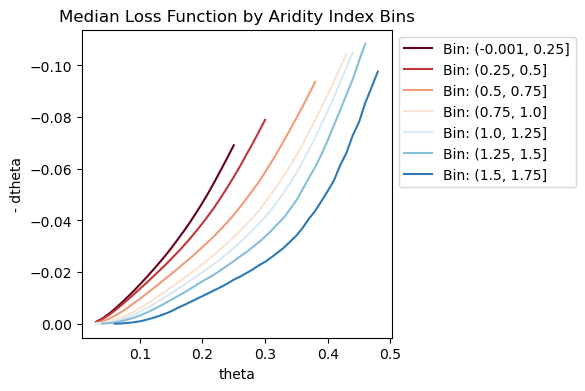

In [1002]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'filtered_df' is your DataFrame and 'sand_fraction' is your continuous variable.


# Bin the 'sand_fraction' into intervals
ai_bins = [i * 0.25 for i in range(8)]
filtered_df['ai_bin'] = pd.cut(filtered_df['AI'], ai_bins, include_lowest=True)
# Get unique bins and sort them
ai_bin = filtered_df['ai_bin'].unique()
ai_bin = [bin for bin in ai_bin if pd.notna(bin)]
ai_bin = sorted(ai_bin, key=lambda x: x.left)  # Sort bins by their left edge

palette = plt.cm.RdBu(np.linspace(0, 1, len(ai_bins)))

# Set the figure size
fig, ax = plt.subplots(figsize=(4, 4))

# Get unique bins

theta = np.arange(0, 1, 0.01)

# Plotting for each sand bin
for i, bin in enumerate(ai_bin):
    bin_data = filtered_df[filtered_df['ai_bin'] == bin]
    
    category_dtheta = []

    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = bin_data['min_sm'].quantile(0.10)
    theta_max = bin_data['max_sm'].quantile(0.90)
    
    for _, row in bin_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        
        # Assuming 'loss_model' is defined and uses 'theta', 'q', 'k', and other parameters
        denormalized_k = k * (theta_max - theta_min)
        dtheta = loss_model(theta, q, denormalized_k, theta_wp=theta_min, theta_star=theta_max)
        category_dtheta.append(dtheta)
    
    # Convert to a DataFrame
    _dtheta_df = pd.DataFrame(category_dtheta, columns=theta)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta_df = _dtheta_df[theta_range]

    # Calculate median for each theta
    median_losses = dtheta_df.median()

    # Plot median line
    ax.plot(theta_range, median_losses, label=f'Bin: {bin}', color=palette[i])

# Customize plot
ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median Loss Function by Aridity Index Bins')

# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()


/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

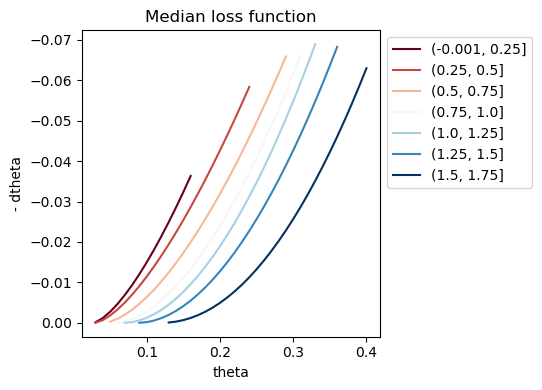

In [42]:
theta = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(figsize=(4, 4))

# Bin the 'sand_fraction' into intervals
ai_bins = [i * 0.25 for i in range(8)]
filtered_df3['ai_bin'] = pd.cut(filtered_df3['AI'], ai_bins, include_lowest=True)
# Get unique bins and sort them
ai_bin = filtered_df3['ai_bin'].unique()
ai_bin = [bin for bin in ai_bin if pd.notna(bin)]
ai_bin = sorted(ai_bin, key=lambda x: x.left)  # Sort bins by their left edge

palette = plt.cm.RdBu(np.linspace(0, 1, len(ai_bin)))

# For each row in the subset, calculate the loss for a range of theta values
for i, category in enumerate(ai_bin):
    category_data = filtered_df3[filtered_df3['ai_bin'] == category]
    
    # Calculate the 10% and 90% of max_sm and min_sm for the theta range
    theta_min = category_data['min_sm'].median() #.quantile(0.10)
    theta_max = category_data['max_sm'].median() #.quantile(0.90)
    denormalized_k = (category_data['q_k'] * (category_data['max_sm']-category_data['min_sm'])).median()
    q = category_data['q_q'].median()

    _dtheta = loss_model(theta, q, denormalized_k, theta_wp=theta_min, theta_star=theta_max)
    theta_range = theta[(theta >= theta_min) & (theta <= theta_max)]
    dtheta = _dtheta[(theta >= theta_min) & (theta <= theta_max)]

    # Plot median line
    ax.plot(theta_range, dtheta, label=f'{category}', color=palette[i])

ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median loss function')

# Adjust the layout so the subplots fit into the figure area
plt.tight_layout()
# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered in power
  d_theta = -k * ( ( theta - theta_wp ) / ( theta_star - theta_wp ) ) ** (q)
/home/raraki/smap-drydown/notebooks/functions.py:13: RuntimeWarning: invalid value encountered 

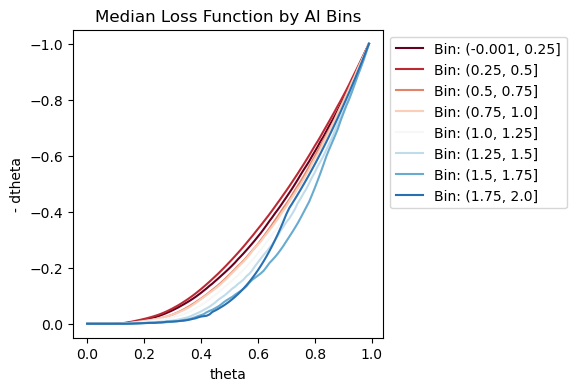

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'filtered_df' is your DataFrame and 'sand_fraction' is your continuous variable.

# Bin the 'sand_fraction' into intervals
ai_bins = [i * 0.25 for i in range(9)]
filtered_df['ai_bin'] = pd.cut(filtered_df['AI'], ai_bins, include_lowest=True)
# Get unique bins and sort them
ai_bin = filtered_df['ai_bin'].unique()
ai_bin = sorted(ai_bin, key=lambda x: x.left)  # Sort bins by their left edge


# Set the figure size
fig, ax = plt.subplots(figsize=(4, 4))

# Get unique bins



theta = np.arange(0, 1, 0.01)

# Plotting for each sand bin
for i, bin in enumerate(ai_bin):
    bin_data = filtered_df[filtered_df['ai_bin'] == bin]
    
    category_dtheta = []

    for _, row in bin_data.iterrows():
        q = row['q_q']
        k = row['q_k']
        
        # Assuming 'loss_model' is defined and uses 'theta', 'q', 'k', and other parameters
        dtheta = loss_model(theta, q, k, theta_wp=theta_min, theta_star=theta_max)
        category_dtheta.append(dtheta)
    
    # Convert to a DataFrame
    dtheta_df = pd.DataFrame(category_dtheta, columns=theta)

    # Calculate median for each theta
    median_losses = dtheta_df.median()
    median_losses_norm = median_losses / median_losses[0.99] * -1

    # Plot median line
    ax.plot(theta, median_losses_norm, label=f'Bin: {bin}', color=palette[i])

# Customize plot
ax.invert_yaxis()
ax.set_xlabel('theta')
ax.set_ylabel('- dtheta')
ax.set_title('Median Loss Function by AI Bins')

# Add a legend
plt.legend(bbox_to_anchor=(1, 1))
# Show the plot
plt.show()


# Filter by range of SM

In [22]:
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace('\n', ' np.nan')
    input_string = input_string.replace(' nan', ' np.nan')
    input_string = input_string.strip('[]')

    # Converting to numpy array and handling np.nan
    sm = np.array([float(value) if value != 'np.nan' else np.nan for value in input_string.split()])

    # Calculating sm_range
    sm_range = (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm) if row.max_sm != row.min_sm else np.nan
    return sm_range

# Applying the function to each row and creating a new column 'sm_range'
filtered_df['sm_range'] = filtered_df.apply(calculate_sm_range, axis=1)

In [23]:
def calculate_sm_avg(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace('\n', ' np.nan')
    input_string = input_string.replace(' nan', ' np.nan')
    input_string = input_string.strip('[]')

    # Converting to numpy array and handling np.nan
    sm = np.array([float(value) if value != 'np.nan' else np.nan for value in input_string.split()])

    # Calculating sm_range
    avg_sm = (np.nanmax(sm) + np.nanmin(sm))/2
    return avg_sm

# Applying the function to each row and creating a new column 'sm_range'
filtered_df['avg_sm'] = filtered_df.apply(calculate_sm_avg, axis=1)

Text(0.5, 0, 'SM range covered within an event')

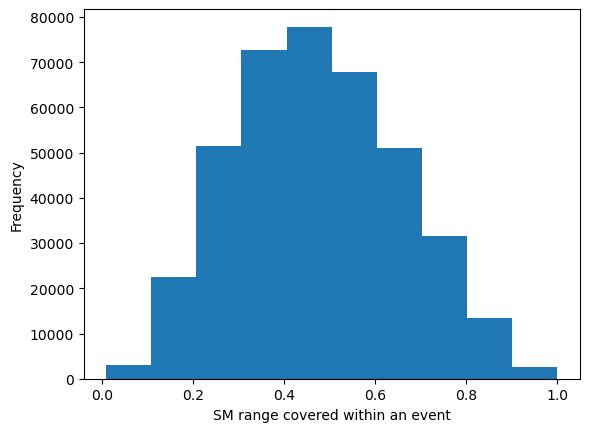

In [24]:
ax = filtered_df['sm_range'].plot.hist()
ax.set_xlabel('SM range covered within an event')

# Parameter comparison

In [25]:
filtered_df3 = filtered_df[filtered_df['sm_range']>0.3].copy()

In [973]:
z = 50
filtered_df3["q_k_dernormalize"] = filtered_df3["q_k"] * (filtered_df3["max_sm"] - filtered_df3["min_sm"]) * z

In [704]:
filtered_df4 = filtered_df3[filtered_df3["q_k_dernormalize"] < 100].copy()

In [ ]:
filtered_df4 = filtered_df3[filtered_df3["q_k_dernormalize"] < 100].copy()

In [726]:
filtered_df5 = filtered_df3[filtered_df3["avg_sm"] > 0.3].copy()

In [974]:
filtered_df3["q_k_dernormalize"]

0         1.123642
1         0.490878
3         1.789702
5         1.665241
6         1.941516
            ...   
588185    1.083774
588188    1.026327
588190    5.635449
588191    6.795269
588193    5.489461
Name: q_k_dernormalize, Length: 391468, dtype: float64

<Axes: ylabel='Frequency'>

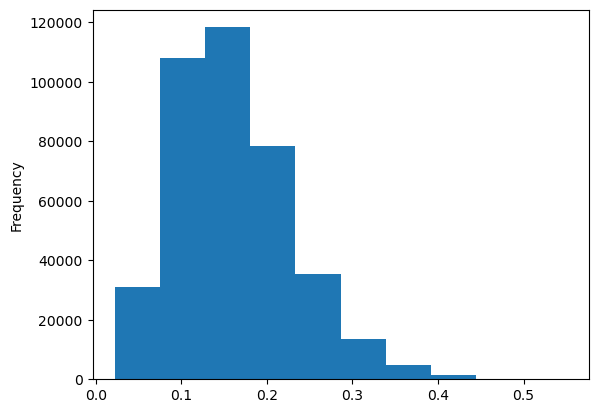

In [975]:
filtered_df3['avg_sm'].plot.hist()

<Axes: ylabel='Frequency'>

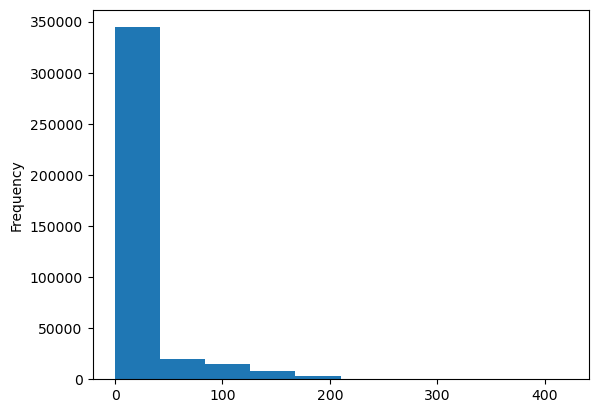

In [976]:
filtered_df3['q_k_dernormalize'].plot.hist()

In [858]:
filtered_df3.groupby("abbreviation").count()

Unnamed: 0  EASE_row_index  EASE_column_index  event_start  \
abbreviation                                                               
BAR                  667             667                667          667   
CNM                 1398            1398               1398         1398   
CRO                 7785            7785               7785         7785   
CSH                  228             228                228          228   
ENF                   58              58                 58           58   
GRA                33737           33737              33737        33737   
OSH                11575           11575              11575        11575   
SAV                  125             125                125          125   
WET                    5               5                  5            5   
WSA                 2898            2898               2898         2898   

              event_end   time     sm  min_sm  max_sm    pet  ...   id_y  \
abbreviation                                                  ...          
BAR                 667    667    667     667     667    667  ...    667   
CNM                1398   1398   1398    1398    1398   1398  ...   1398   
CRO                7785   7785   7785    7785    7785   7785  ...   7785   
CSH                 228    228    228     228     228    228  ...    228   
ENF                  58     58     58      58      58     58  ...     58   
GRA               33737  33737  33737   33737   33737  33737  ...  33737   
OSH               11575  11575  11575   11575   11575  11575  ...  11575   
SAV                 125    125    125     125     125    125  ...    125   
WET                   5      5      5       5       5      5  ...      5   
WSA                2898   2898   2898    2898    2898   2898  ...   2898   

                 AI  class   name  description  _diff_R2  q_k_dernormalize  \
abbreviation                                                                 
BAR             667    667    667          667       667               667   
CNM            1398   1398   1398         1398      1398              1398   
CRO            7785   7785   7785         7785      7785              7785   
CSH             228    228    228          228       228               228   
ENF              58     58     58           58        58                58   
GRA           33737  33737  33737        33737     33737             33737   
OSH           11575  11575  11575        11575     11575             11575   
SAV             125    125    125          125       125               125   
WET               5      5      5            5         5                 5   
WSA            2898   2898   2898         2898      2898              2898   

              q_AET/PET  sm_range  avg_sm  
abbreviation                               
BAR                 667       667     667  
CNM                1398      1398    1398  
CRO                7785      7785    7785  
CSH                 228       228     228  
ENF                  58        58      58  
GRA               33737     33737   33737  
OSH               11575     11575   11575  
SAV                 125       125     125  
WET                   5         5       5  
WSA                2898      2898    2898  

[10 rows x 35 columns]

In [977]:
def plot_scatter_with_errorbar(target_df, quantile, categories, colors, x_varname, x_label, y_varname, y_label, x_max, y_max):
    plt.figure(figsize=(5, 5))
    stats_dict = {}

    # Calculate median and 90% confidence intervals for each vegetation class
    for i, category in enumerate(categories):
        
        subset = target_df[target_df['abbreviation'] == category]
        
        # Median calculation
        x_median = subset[x_varname].median()
        y_median = subset[y_varname].median()
        
        # 90% CI calculation, using the 5th and 95th percentiles
        x_ci_low, x_ci_high = np.percentile(subset[x_varname], [quantile, 100-quantile])
        y_ci_low, y_ci_high = np.percentile(subset[y_varname], [quantile, 100-quantile])
        
        # Store in dict
        stats_dict[category] = {
            'x_median': x_median,
            'y_median': y_median,
            'x_ci': (x_median - x_ci_low, x_ci_high - x_median),
            'y_ci': (y_median - y_ci_low, y_ci_high - y_median),
            'color': colors[i]
        }

    # Now plot medians with CIs
    for category, stats in stats_dict.items():
        plt.errorbar(stats['x_median'], stats['y_median'],
                    xerr=np.array([[stats['x_ci'][0]], [stats['x_ci'][1]]]),
                    yerr=np.array([[stats['y_ci'][0]], [stats['y_ci'][1]]]),
                    fmt='o', label=category, capsize=5, capthick=2, color=stats['color'], alpha=0.7,markersize=10 , mec='darkgray', mew=1)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Median Scatter Plot with {quantile}% CI')

    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xscale('log')
    plt.xlim(None, x_max)
    plt.ylim(0.0, y_max)

    # Show the plot
    plt.show()

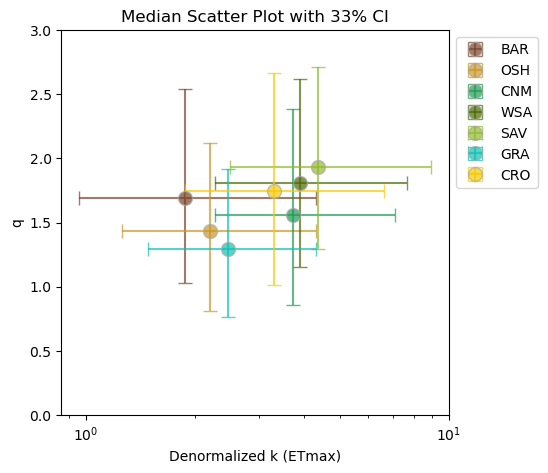

In [1006]:
# Define the specific order for your categories.
vegetation_categories = ["BAR", "OSH", "CNM", "WSA", "SAV", "GRA", "CRO"]
colors = ["#7A422A", "#C99728", "#229954", "#4C6903", "#92BA31", "#13BFB2", "#F7C906"]

plot_scatter_with_errorbar(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="q_k_dernormalize", x_label="Denormalized k (ETmax)", y_varname="q_q", y_label="q", x_max=10, y_max=3.0)

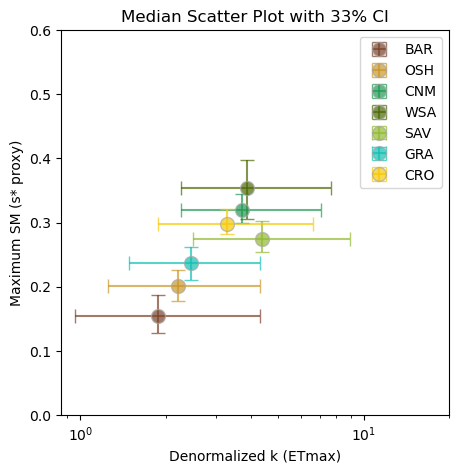

In [1007]:
plot_scatter_with_errorbar(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="q_k_dernormalize", x_label="Denormalized k (ETmax)", y_varname="max_sm", y_label="Maximum SM (s* proxy)", x_max=20, y_max=0.6)

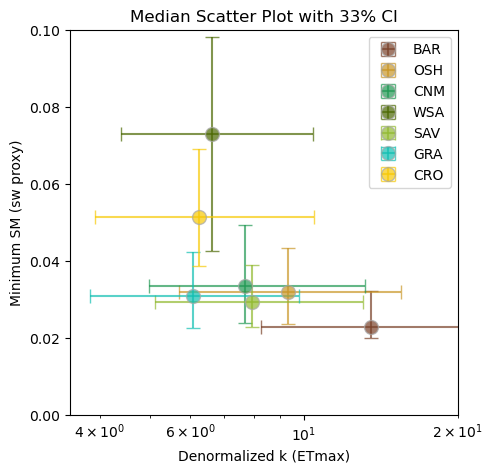

In [1008]:
plot_scatter_with_errorbar(target_df=filtered_df4, quantile=33, categories=vegetation_categories, colors=colors, x_varname="q_k_dernormalize", x_label="Denormalized k (ETmax)", y_varname="min_sm", y_label="Minimum SM (sw proxy)", x_max=20, y_max=0.1)

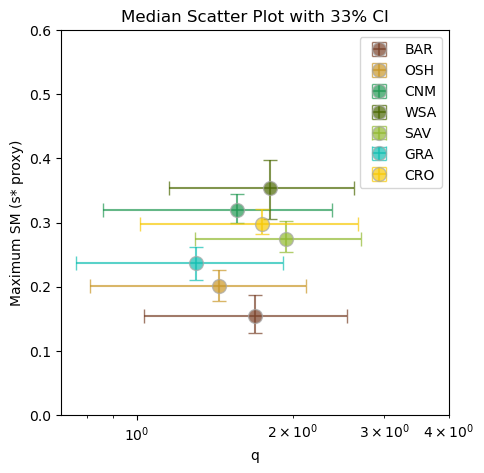

In [1009]:
plot_scatter_with_errorbar(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="q_q", x_label="q", y_varname="max_sm", y_label="Maximum SM (s* proxy)", x_max=4.0, y_max=0.6)

# Parameter gradient with PET change

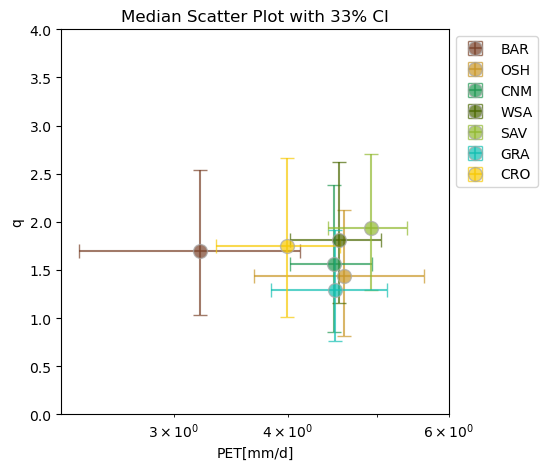

In [1010]:
plot_scatter_with_errorbar(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="pet", x_label="PET[mm/d]", y_varname="q_q", y_label="q", x_max=6, y_max=4.0)

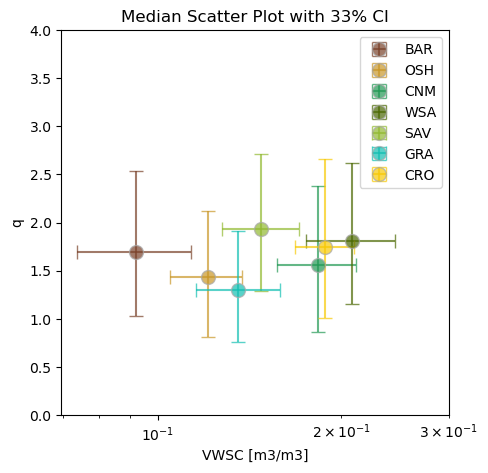

In [1011]:
plot_scatter_with_errorbar(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="avg_sm", x_label="VWSC [m3/m3]", y_varname="q_q", y_label="q", x_max=0.3, y_max=4.0)

In [1012]:
import seaborn as sns
from scipy.stats import linregress

In [985]:
def plot_trendline(target_df, quantile, categories, colors, x_varname, x_label, y_varname, y_label, x_max, y_max):
    plt.figure(figsize=(5, 5))
    stats_dict = {}

    # Calculate median and 90% confidence intervals for each vegetation class
    for i, category in enumerate(categories):
        subset = target_df[target_df['abbreviation'] == category]
        
        # Calculate the linear regression (trend line)
        slope, intercept, r_value, p_value, std_err = linregress(subset[x_varname], subset[y_varname])
        
        # Generate x values for the trend line
        x_values = np.linspace(0, x_max, 100)
        
        # Calculate the y values based on the slope and intercept
        y_values = slope * x_values + intercept
        
        # Plot the trend line
        plt.plot(x_values, y_values, label=f"{category} Trend", alpha=0.7, color=colors[i])

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlim(0.0, x_max)
    plt.ylim(0.0, y_max)

    # Show the plot
    plt.show()

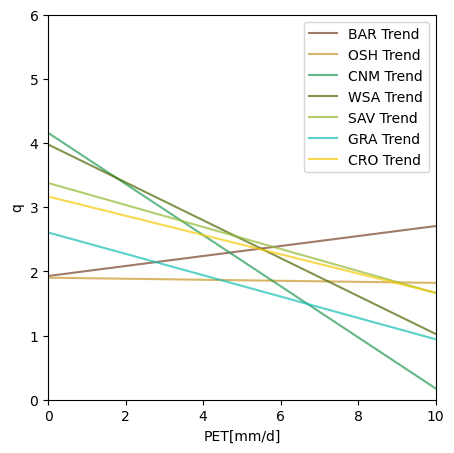

In [986]:
plot_trendline(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="pet", x_label="PET[mm/d]", y_varname="q_q", y_label="q", x_max=10, y_max=6)

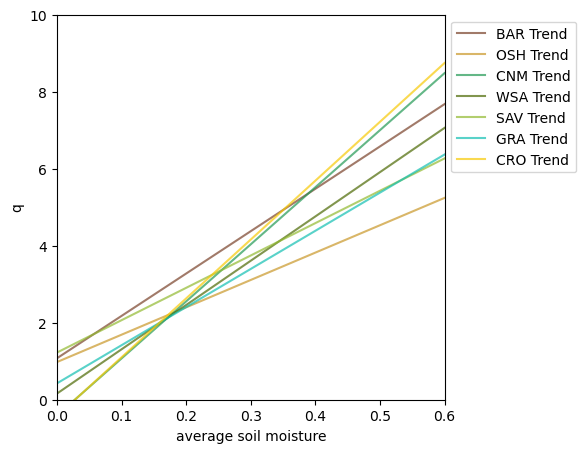

In [987]:
plot_trendline(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="avg_sm", x_label="average soil moisture", y_varname="q_q", y_label="q", x_max=0.6, y_max=10)

In [81]:

def plot_scatter(target_df, quantile, categories, colors, x_varname, x_label, y_varname, y_label, x_max, y_max):
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))
    axs = axs.flatten() 
    stats_dict = {}

    # Calculate median and 90% confidence intervals for each vegetation class
    for i, category in enumerate(categories):
        subset = target_df[target_df['abbreviation'] == category]
        ax = axs[i]
        # Plot the trend line
        ax.scatter(subset[x_varname],  subset[y_varname], label=f"{category} Trend", alpha=0.7, color=colors[i])
        ax.set_xlim(0.0, x_max)
        ax.set_ylim(0.0, y_max)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(category)

    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))


    # Show the plot
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


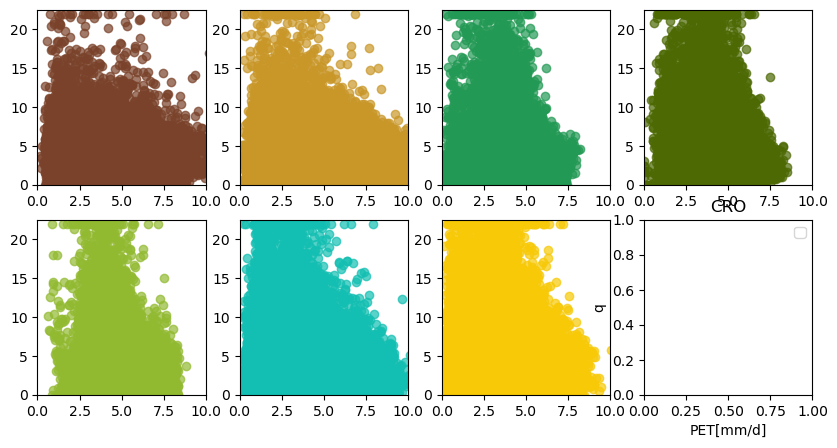

In [82]:
plot_scatter(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="pet", x_label="PET[mm/d]", y_varname="q_q", y_label="q", x_max=10, y_max=22.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


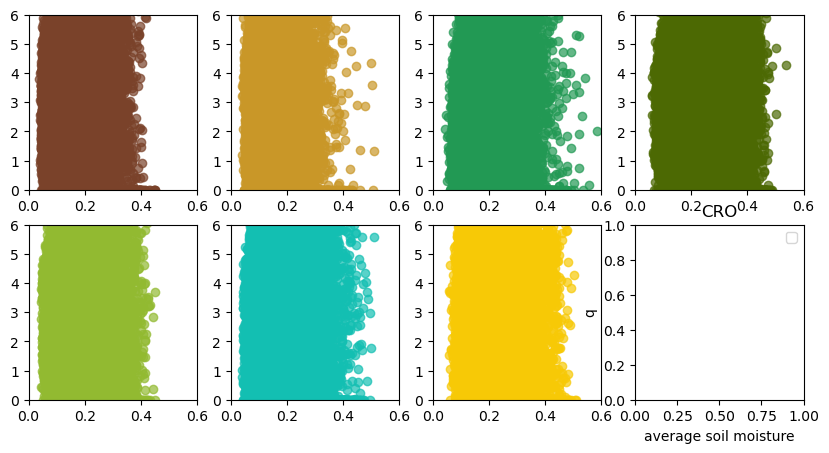

In [83]:
plot_scatter(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="avg_sm", x_label="average soil moisture", y_varname="q_q", y_label="q", x_max=0.6, y_max=6)

In [988]:

def plot_kde(target_df, quantile, categories, colors, x_varname, x_label, y_varname, y_label, x_max, y_max):
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))
    axs = axs.flatten() 
    stats_dict = {}

    # Calculate median and 90% confidence intervals for each vegetation class
    for i, category in enumerate(categories):
        subset = target_df[target_df['abbreviation'] == category]
        ax = axs[i]
        # Plot the trend line
        sns.kdeplot(data=subset, x=x_varname, y=y_varname, ax=ax, fill=True, color=colors[i])

        # Add labels and title
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(category)
        ax.set_xlim(0.0, x_max)
        ax.set_ylim(0.0, y_max)

    # Show the plot
    plt.tight_layout()
    plt.show()

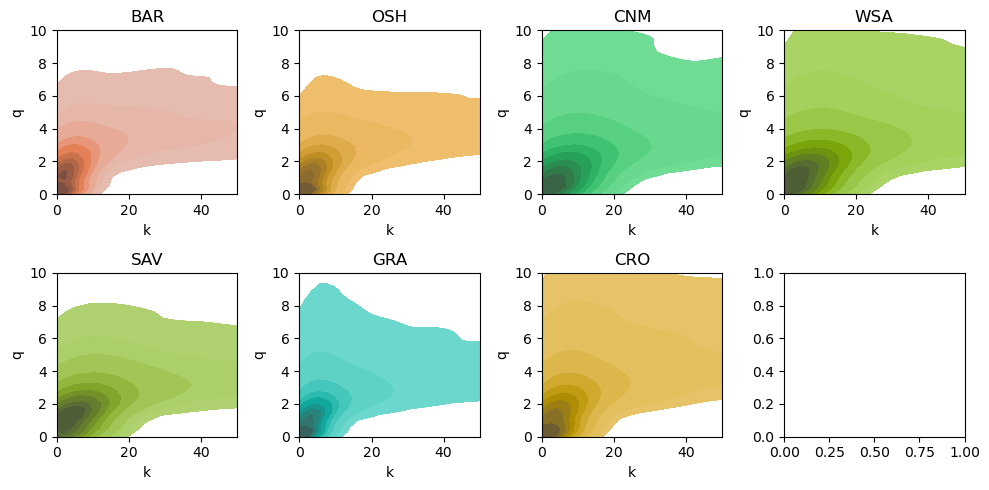

In [989]:
plot_kde(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="q_k_dernormalize", x_label="k", y_varname="q_q", y_label="q", x_max=50, y_max=10)

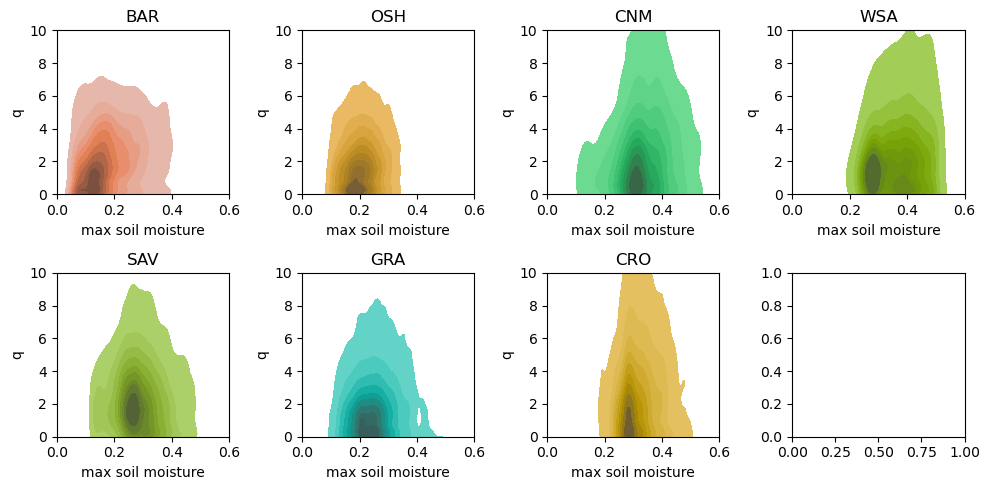

In [990]:
plot_kde(target_df=filtered_df3, quantile=33, categories=vegetation_categories, colors=colors, x_varname="max_sm", x_label="max soil moisture", y_varname="q_q", y_label="q", x_max=0.6, y_max=10)

In [91]:
from scipy.stats import gaussian_kde

In [820]:
# Assuming df is your DataFrame with 'q', 'avg_sm', and 'PET' columns

def plot_3d_kde(df):
        data = np.vstack([df['q_q'], df['avg_sm'], df['pet']])
        kde = gaussian_kde(data)

        # Calculate the 30th percentile for each variable
        q_30th = np.percentile(df['q_q'], 30)
        avg_sm_30th = np.percentile(df['avg_sm'], 30)
        pet_30th = np.percentile(df['pet'], 30)


        # Create a grid over which we will evaluate kde
        # Create a grid over which we will evaluate kde
        xmin, xmax = min(df['q_q'].min(), q_30th), max(df['q_q'].max(), q_30th)
        ymin, ymax = min(df['avg_sm'].min(), avg_sm_30th), max(df['avg_sm'].max(), avg_sm_30th)
        zmin, zmax = min(df['pet'].min(), pet_30th), max(df['pet'].max(), pet_30th)

        xgrid, ygrid, zgrid = np.meshgrid(np.linspace(xmin, xmax, 100), 
                                        np.linspace(ymin, ymax, 100), 
                                        np.linspace(zmin, zmax, 100))

        # Evaluate kde on grid
        kde_values = kde(np.vstack([xgrid.ravel(), ygrid.ravel(), zgrid.ravel()]))

        # Reshape kde_values to the shape of the grid
        kde_values = kde_values.reshape(xgrid.shape)

        # Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Use imshow to plot kde
        ax.imshow(np.rot90(kde_values), cmap='hot',
                extent=[xmin, xmax, ymin, ymax, zmin, zmax])

        # Set labels
        ax.set_xlabel('q')
        ax.set_ylabel('avg_sm')
        ax.set_zlabel('PET')

        plt.show()

In [821]:
plot_3d_kde(filtered_df3)

NameError: name 'gaussian_kde' is not defined